# Initial model training

Importing relevant libraries

In [3]:
import numpy as np
import math
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn import preprocessing
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
%matplotlib inline
#Keras modules
import keras.metrics
from keras.models import Sequential
from keras.layers import Dense, Activation, Input
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Model

Using TensorFlow backend.


In [4]:
#Function to create a confusion matrix
def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes =unique_labels(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    fig, ax = plt.subplots()
    plt.grid(b=None)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
  
    return ax

In [5]:
#Functino to select relevant fields from the csv files
def selectFields(df):
    new = df.filter(['ada_score','AF','BLOSUM62','codon_degeneracy','Eigen-pred_coding','GERP++_RS', 
              'integrated_fitCons_score','LoFtool','phyloP100way_vertebrate','SIFT','Consequence'])
    return new

In [6]:
#Function to replace empty values
def fillEmpty(df):
    df = df.replace({'ada_score': "-", 'AF': "-", 'Eigen-pred_coding': '-',
               'integrated_fitCons_score': '-', 'LoFtool': '-', 'phyloP100way_vertebrate':'-',
               'SIFT': '-'}, -1)
    df = df.replace({'BLOSUM62':"-", 'GERP++_RS':'-'}, 0)
    return df

In [7]:
#Function to split codon degeneracy field
def splitCodonDeg (df):
    df['codon_degeneracy'] = df['codon_degeneracy'].str.split(',').str[0]
    df['Consequence'] = df['Consequence'].str.split(',').str[0]
    df = df.replace({'codon_degeneracy':'-'},0)
    return df
                

In [8]:
#Function to split VEST4 field
def splitVEST (df):
    df['VEST4_score'] = df['VEST4_score'].str.split(',').str[0]
    df['VEST4_score'] = df['VEST4_score'].str.split(',').str[0]
    df = df.replace({'VEST4_score':'.'},0)
    df = df.replace({'VEST4_score':np.nan},0)
    return df

In [9]:
# Importing datasets
ben = pd.read_csv('BEN_2020.txt', sep='\t')
pat = pd.read_csv('PAT_2020.txt', sep='\t')
vus = pd.read_csv('VUS_2020.txt', sep='\t')
ben_exvus = pd.read_csv('EXVUS_BEN_2020.txt', sep='\t')
pat_exvus = pd.read_csv('EXVUS_PAT_2020.txt', sep='\t')
ponp2 = pd.read_csv('ponp2columns.csv', sep='\t')

/home/bioinformatic/anaconda3/envs/vusprize/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (6,21) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [10]:
# Processing datasets
ben_fields = selectFields(ben)
pat_fields = selectFields(pat)
vus_fields = selectFields(vus)
ben_ex_fields = selectFields(ben_exvus)
pat_ex_fields = selectFields(pat_exvus)
ben_full = fillEmpty( ben_fields)
pat_full = fillEmpty( pat_fields )
vus_full = fillEmpty( vus_fields )
ben_ex_full = fillEmpty (ben_ex_fields)
pat_ex_full = fillEmpty (pat_ex_fields)
ben_ok = splitCodonDeg (ben_full)
pat_ok = splitCodonDeg (pat_full)
vus_ok = splitCodonDeg (vus_full)
ben_ex_ok = splitCodonDeg (ben_ex_full)
pat_ex_ok = splitCodonDeg (pat_ex_full)
ben_ok['CLINSIG']=0
pat_ok['CLINSIG']=1
set_ok = pd.concat([ben_ok, pat_ok])
ben_ex_ok['CLINSIG']=0
pat_ex_ok['CLINSIG']=1
set_ex_ok= pd.concat([ben_ex_ok,pat_ex_ok])
set_dummies=pd.get_dummies(set_ok,columns=['Consequence'])
set_ex_dummies=pd.get_dummies(set_ex_ok,columns=['Consequence'])
scaler = MinMaxScaler(feature_range=(0, 1), copy=True)
scaler.fit(set_dummies)
scaler.fit(set_ex_dummies)
set_float = set_dummies.astype(float)
set_ex_float = set_ex_dummies.astype(float)

In [11]:
#Creation of initial training and testing sets
X = set_float.drop(['CLINSIG'],axis=1)
y=set_float['CLINSIG']
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)
X_test.to_csv(r'X_test.csv',index=False)
y_test.to_csv(r'y_test.csv',index=False)

In [12]:
#Training Random Forest model
rfc=RandomForestClassifier(random_state=2, class_weight = "balanced", n_jobs=3)
param_grid = { 
    'n_estimators': [128,256,512,1024],
    'max_depth' : [4,7,10,15],
    'criterion' :['gini', 'entropy']
}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5, scoring='roc_auc')
CV_rfc.fit(X_train, y_train)
rf_bests=CV_rfc.best_params_
clf_RF = RandomForestClassifier(n_jobs=3,n_estimators=rf_bests['n_estimators'], 
                                max_depth=rf_bests['max_depth'], 
                                class_weight="balanced",
                                random_state=2, 
                                criterion=rf_bests['criterion'])
modelo=clf_RF.fit(X_train,y_train)
prediction_RF=clf_RF.predict(X_test)

              precision    recall  f1-score   support

         0.0       0.99      0.94      0.96     10199
         1.0       0.89      0.98      0.93      5011

    accuracy                           0.95     15210
   macro avg       0.94      0.96      0.95     15210
weighted avg       0.96      0.95      0.95     15210

MCC:  0.8967594106463371
Log Loss:  1.6508992895156145
Normalized confusion matrix
Confusion matrix, without normalization


<AxesSubplot:title={'center':'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

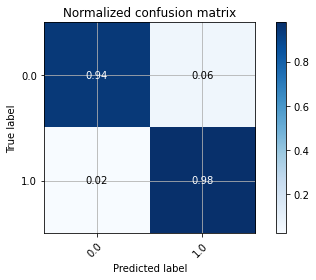

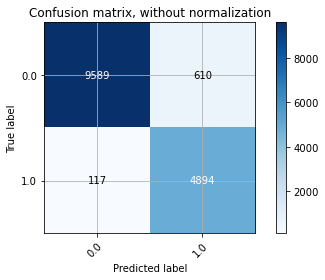

In [16]:
print(classification_report(y_test,prediction_RF))
print('MCC: ', matthews_corrcoef(y_test,prediction_RF))
print('Log Loss: ', log_loss(y_test,prediction_RF))
plot_confusion_matrix(y_test, prediction_RF.astype(int), True)
plot_confusion_matrix(y_test, prediction_RF.astype(int), False)

In [17]:
#Feature importances from the RF Model
importances = pd.DataFrame(clf_RF.feature_importances_, index=X_train.columns)
importances = importances.sort_values(by=[0])
importances

,0
Consequence_protein_altering_variant,0.000009
Consequence_TF_binding_site_variant,0.000010
Consequence_stop_lost,0.000011
Consequence_stop_retained_variant,0.000018
Consequence_start_lost,0.000342
Consequence_inframe_insertion,0.000369
Consequence_3_prime_UTR_variant,0.000418
Consequence_downstream_gene_variant,0.000686
Consequence_inframe_deletion,0.000928
Consequence_5_prime_UTR_variant,0.001007


In [ ]:
#Training SVM model

svm_modelo = svm.SVC(probability=True)
param_grid = { 
    'C': [0.1,1,10],
    'gamma' : [0.01,0.1,1],
    'kernel' :['rbf']
}
CV_svm = GridSearchCV(estimator=svm_modelo, param_grid=param_grid, cv= 3, scoring='roc_auc')
CV_svm.fit(X_train, y_train)
best_svm=CV_svm.best_params_

In [56]:
best_svm={'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}

              precision    recall  f1-score   support

         0.0       0.95      0.96      0.96     10199
         1.0       0.93      0.90      0.91      5011

    accuracy                           0.94     15210
   macro avg       0.94      0.93      0.93     15210
weighted avg       0.94      0.94      0.94     15210

MCC:  0.8671756032523048
Log loss:  2.0142133409699507
Normalized confusion matrix
Confusion matrix, without normalization


<AxesSubplot:title={'center':'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

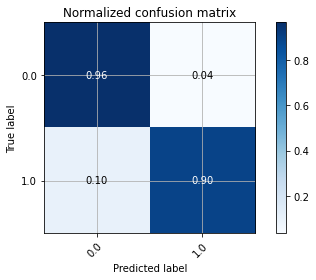

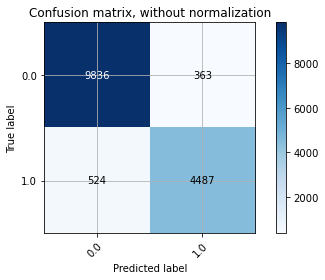

In [57]:
svm_modelo = svm.SVC(probability = True, C=best_svm['C'], gamma=best_svm['gamma'],kernel=best_svm['kernel'])
svm_modelo.fit(X_train,y_train)
prediction_svm=svm_modelo.predict(X_test)
print(classification_report(y_test,prediction_svm))
print('MCC: ',matthews_corrcoef(y_test,prediction_svm))
print('Log loss: ',log_loss(y_test,prediction_svm))
plot_confusion_matrix(y_test, prediction_svm.astype(int), True)
plot_confusion_matrix(y_test, prediction_svm.astype(int), False)

In [15]:
best_svm

{'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}

In [20]:
# Function to create MLP

def perceptron_multi(X,y):
    perceptron_multicapa = Sequential()
    perceptron_multicapa.add(Dense(20, input_dim=X.shape[1], activation='relu'))
    perceptron_multicapa.add(Dense(10, input_dim=X.shape[1], activation='relu'))
    perceptron_multicapa.add(Dense(10, input_dim=X.shape[1], activation='relu'))
    perceptron_multicapa.add(Dense(10, input_dim=X.shape[1], activation='relu'))
    perceptron_multicapa.add(Dense(10, input_dim=X.shape[1], activation='relu'))
    #perceptron_multicapa.add(Dense(10, activation='relu'))
    perceptron_multicapa.add(Dense(1, activation='sigmoid'))
    perceptron_multicapa.compile(optimizer='adam',
                                 loss='binary_crossentropy',
                                 metrics=['accuracy', keras.metrics.Recall()]
                                )
    perceptron_multicapa.fit(X, y, epochs=25, batch_size=50)
    return perceptron_multicapa

In [21]:
#Training MLP model
red_modelo = perceptron_multi(X_train, y_train.astype(float))

2021-12-28 10:34:43.569976: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2021-12-28 10:34:43.682526: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 3099995000 Hz
2021-12-28 10:34:43.683935: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x563f18f38d00 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-12-28 10:34:43.683987: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2021-12-28 10:34:43.726620: I tensorflow/core/common_runtime/process_util.cc:147] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Epoch 1/25
60839/60839 [==============================] - 4s 66us/step - loss: 0.1773 - accuracy: 0.9230 - recall_1: 0.8682
Epoch 2/25
60839/60839 [==============================] - 2s 40us/step - loss: 0.1280 - accuracy: 0.9428 - recall_1: 0.9158
Epoch 3/25
60839/60839 [==============================] - 2s 35us/step - loss: 0.1263 - accuracy: 0.9439 - recall_1: 0.9132
Epoch 4/25
60839/60839 [==============================] - 2s 36us/step - loss: 0.1246 - accuracy: 0.9438 - recall_1: 0.9139
Epoch 5/25
60839/60839 [==============================] - 2s 37us/step - loss: 0.1239 - accuracy: 0.9445 - recall_1: 0.9165
Epoch 6/25
60839/60839 [==============================] - 2s 32us/step - loss: 0.1229 - accuracy: 0.9447 - recall_1: 0.9158
Epoch 7/25
60839/60839 [==============================] - 3s 46us/step - loss: 0.1220 - accuracy: 0.9454 - recall_1: 0.9176
Epoch 8/25
60839/60839 [==============================] - 2s 38us/step - loss: 0.1215 - accuracy: 0.9458 - recall_1: 0.9162
Epoch 9/

In [22]:
print(red_modelo.predict_classes(X_test).astype(int))

[[0]
 [0]
 [0]
 ...
 [0]
 [1]
 [0]]


              precision    recall  f1-score   support

         0.0       0.97      0.95      0.96     10199
         1.0       0.91      0.95      0.93      5011

    accuracy                           0.95     15210
   macro avg       0.94      0.95      0.94     15210
weighted avg       0.95      0.95      0.95     15210

MCC:  0.8885052793496951
Log loss:  1.7281000814242402
Normalized confusion matrix
Confusion matrix, without normalization


<AxesSubplot:title={'center':'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

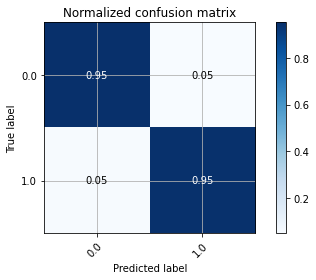

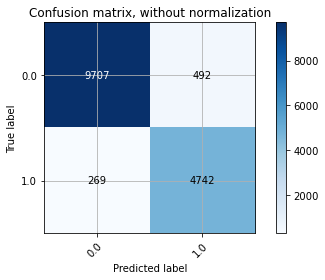

In [23]:
print(classification_report(y_test,red_modelo.predict_classes(X_test).astype(int)))
print('MCC: ',matthews_corrcoef(y_test,red_modelo.predict_classes(X_test).astype(int)))
print('Log loss: ', log_loss(y_test,red_modelo.predict_classes(X_test).astype(int)))
plot_confusion_matrix(y_test, red_modelo.predict_classes(X_test).astype(int), True)
plot_confusion_matrix(y_test, red_modelo.predict_classes(X_test).astype(int), False)

Instructions for updating:
Please use `model.predict()` instead.


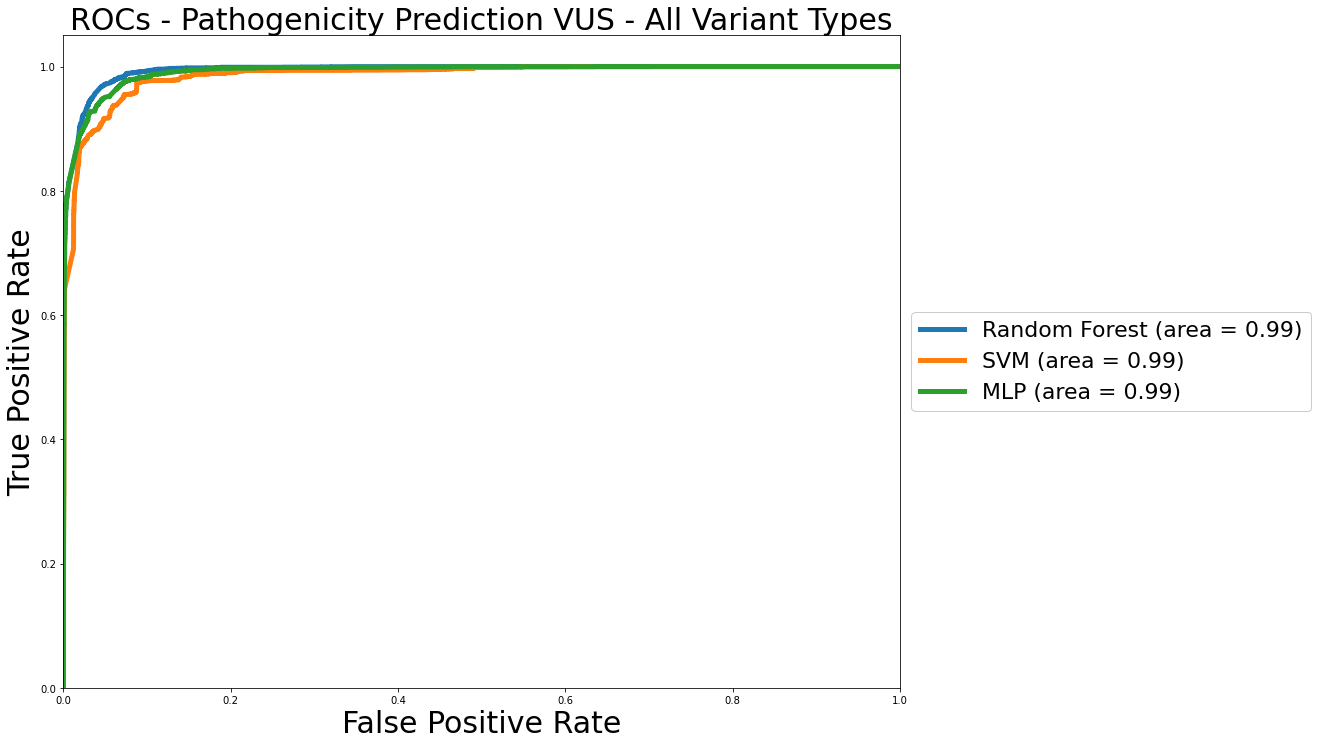

In [20]:
#Model ROCs

score_RF=clf_RF.predict_proba(X_test)
score_RF
fpr_RF, tpr_RF, threshs = metrics.roc_curve(y_test,score_RF[:,1])
roc_auc_RF= auc(fpr_RF, tpr_RF)

score_SVM=svm_modelo.predict_proba(X_test)
score_SVM
fpr_SVM, tpr_SVM, threshs = metrics.roc_curve(y_test,score_SVM[:,1])
roc_auc_SVM= auc(fpr_SVM, tpr_SVM)

red_probas = red_modelo.predict_proba(X_test)
fpr_MLP, tpr_MLP, threshs = metrics.roc_curve(y_test, red_probas)
roc_auc_mlp= auc(fpr_MLP, tpr_MLP)

#fpr_CADD, tpr_CADD, threshs= metrics.roc_curve(y_test,X_test['CADD_PHRED'])
#roc_auc_CADD= auc(fpr_CADD, tpr_CADD)
#plt.close('all')

plt.figure(figsize=(15, 12))
lw = 2

plt.plot(fpr_RF,tpr_RF,
         lw=5, label='Random Forest (area = %0.2f)' % roc_auc_RF)
plt.plot(fpr_SVM,tpr_SVM, 
         lw=5, label='SVM (area = %0.2f)' % roc_auc_SVM)
plt.plot(fpr_MLP, tpr_MLP, 
         lw=5, label='MLP (area = %0.2f)' % roc_auc_mlp)

#plt.plot(fpr_CADD, tpr_CADD,
#         lw=lw, label='CADD (area = %0.2f)' % roc_auc_CADD)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=30)
plt.ylabel('True Positive Rate',fontsize=30)
plt.title('ROCs - Pathogenicity Prediction VUS - All Variant Types',fontsize=30)
plt.legend(fontsize=22,loc='center left', bbox_to_anchor=(1, 0.5),framealpha=1,frameon=1)

In [27]:
fpr_RF, tpr_RF, threshs = metrics.roc_curve(y_test,score_RF[:,1])
rfAUC_all = pd.DataFrame()
rfAUC_all['Threshold']=pd.Series(threshs)
rfAUC_all['TPR']=pd.Series(tpr_RF)
rfAUC_all['FPR']=pd.Series(fpr_RF)
rfAUC_all

,Threshold,TPR,FPR
0,1.999955,0.000000,0.000000
1,0.999955,0.000200,0.000000
2,0.999901,0.013371,0.000000
3,0.999901,0.013770,0.000000
4,0.999873,0.019158,0.000000
...,...,...,...
1910,0.000871,1.000000,0.998431
1911,0.000845,1.000000,0.998627
1912,0.000840,1.000000,0.998823
1913,0.000840,1.000000,0.999510


In [28]:
fpr_SVM, tpr_SVM, threshs = metrics.roc_curve(y_test,score_SVM[:,1])
svmAUC_all = pd.DataFrame()
svmAUC_all['Threshold']=pd.Series(threshs)
svmAUC_all['TPR']=pd.Series(tpr_SVM)
svmAUC_all['FPR']=pd.Series(fpr_SVM)
svmAUC_all

,Threshold,TPR,FPR
0,1.999999,0.000000,0.000000
1,0.999999,0.000200,0.000000
2,0.999995,0.014568,0.000000
3,0.999995,0.014568,0.000098
4,0.999994,0.016364,0.000098
...,...,...,...
1633,0.000151,1.000000,0.977351
1634,0.000151,1.000000,0.977547
1635,0.000102,1.000000,0.984508
1636,0.000102,1.000000,0.984704


In [29]:
fpr_MLP, tpr_MLP, threshs = metrics.roc_curve(y_test, red_probas)
mlpAUC_all = pd.DataFrame()
mlpAUC_all['Threshold']=pd.Series(threshs)
mlpAUC_all['TPR']=pd.Series(tpr_MLP)
mlpAUC_all['FPR']=pd.Series(fpr_MLP)
mlpAUC_all

,Threshold,TPR,FPR
0,2.000000,0.000000,0.000000
1,1.000000,0.000200,0.000000
2,0.999891,0.005189,0.000000
3,0.999890,0.005189,0.000098
4,0.999599,0.019357,0.000098
...,...,...,...
1846,0.000036,1.000000,0.975684
1847,0.000036,1.000000,0.976076
1848,0.000035,1.000000,0.978331
1849,0.000035,1.000000,0.978527


<ipython-input-34-fc76ace3f68b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  both['CLINSIG']=y_test


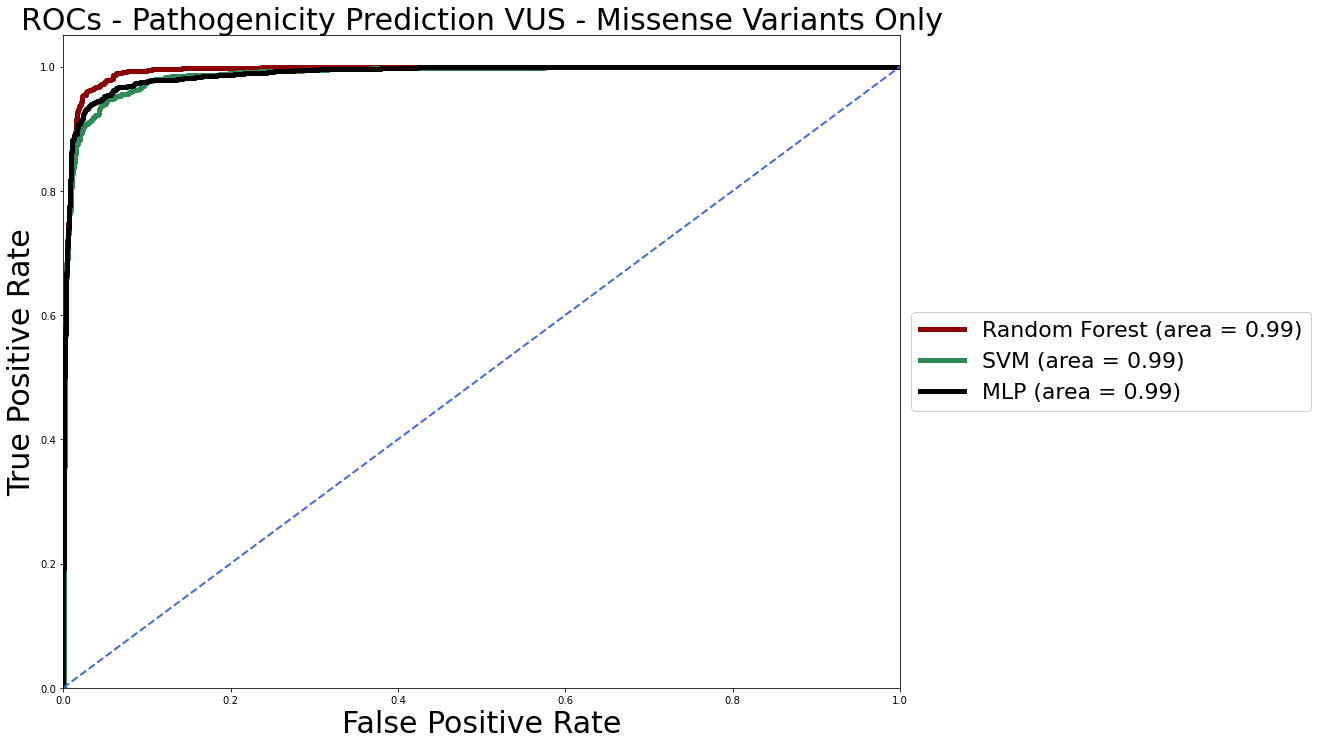

In [34]:
#Model ROCs - "missense" variants only

both = X_test
both['CLINSIG']=y_test
both_miss = both[both['Consequence_missense_variant']==1]
X_miss = both_miss.drop(['CLINSIG'],axis=1)
y_miss = both_miss['CLINSIG']

score_RF_miss=clf_RF.predict_proba(X_miss)
score_RF_miss
fpr_RF_miss, tpr_RF_miss, threshs = metrics.roc_curve(y_miss,score_RF_miss[:,1])
roc_auc_RF_miss= auc(fpr_RF_miss, tpr_RF_miss)
rfAUC_miss = pd.DataFrame()
rfAUC_miss['Threshold']=pd.Series(threshs)
rfAUC_miss['TPR']=pd.Series(tpr_RF_miss)
rfAUC_miss['FPR']=pd.Series(fpr_RF_miss)
rfAUC_miss.to_csv(r'rfAUC_miss.csv',index=False)

score_SVM_miss=svm_modelo.predict_proba(X_miss)
score_SVM_miss
fpr_SVM_miss, tpr_SVM_miss, threshs = metrics.roc_curve(y_miss,score_SVM_miss[:,1])
roc_auc_SVM_miss= auc(fpr_SVM_miss, tpr_SVM_miss)
svmAUC_miss = pd.DataFrame()
svmAUC_miss['Threshold']=pd.Series(threshs)
svmAUC_miss['TPR']=pd.Series(tpr_SVM_miss)
svmAUC_miss['FPR']=pd.Series(fpr_SVM_miss)
svmAUC_miss.to_csv(r'svmAUC_miss.csv',index=False)

red_probas_miss = red_modelo.predict_proba(X_miss)
fpr_MLP_miss, tpr_MLP_miss, thresholds = metrics.roc_curve(y_miss, red_probas_miss)
roc_auc_mlp_miss= auc(fpr_MLP_miss, tpr_MLP_miss)
mlpAUC_miss = pd.DataFrame()
mlpAUC_miss['Threshold']=pd.Series(threshs)
mlpAUC_miss['TPR']=pd.Series(tpr_MLP_miss)
mlpAUC_miss['FPR']=pd.Series(fpr_MLP_miss)
mlpAUC_miss.to_csv(r'mlpAUC_miss.csv',index=False)

#fpr_CADD_miss, tpr_CADD_miss, threshs= metrics.roc_curve(y_miss,X_miss['CADD_PHRED'])
#roc_auc_CADD_miss= auc(fpr_CADD_miss, tpr_CADD_miss)

plt.close('all')

plt.figure(figsize=(15, 12))
lw = 2

plt.plot(fpr_RF_miss,tpr_RF_miss, color='darkred',
         lw=5, label='Random Forest (area = %0.2f)' % roc_auc_RF_miss)
plt.plot(fpr_SVM_miss,tpr_SVM_miss, color='seagreen',
         lw=5, label='SVM (area = %0.2f)' % roc_auc_SVM_miss)
plt.plot(fpr_MLP_miss, tpr_MLP_miss, color='black',
         lw=5, label='MLP (area = %0.2f)' % roc_auc_mlp_miss)
plt.plot([0, 1], [0, 1], color='royalblue', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=30)
plt.ylabel('True Positive Rate',fontsize=30)
plt.title('ROCs - Pathogenicity Prediction VUS - Missense Variants Only',fontsize=30)
plt.legend(fontsize=22,loc='center left', bbox_to_anchor=(1, 0.5),framealpha=1,frameon=1)



In [33]:
 rfAUC_miss

,Threshold,TPR,FPR
0,1.997955,0.000000,0.000000
1,0.997955,0.000927,0.000000
2,0.996367,0.012048,0.000000
3,0.996364,0.013902,0.000000
4,0.994724,0.063948,0.000000
...,...,...,...
160,0.052582,0.998146,0.236654
161,0.052352,0.999073,0.236654
162,0.019583,0.999073,0.419373
163,0.019547,1.000000,0.419373


# Benchmarking with the ex VUS set

In [47]:
ponp2['clinsig']

0       1
1       1
2       1
3       1
4       1
       ..
2282    0
2283    0
2284    0
2285    0
2286    0
Name: clinsig, Length: 2287, dtype: int64

In [48]:
fpr_p, tpr_p, threshs_p= metrics.roc_curve(ponp2['clinsig'],ponp2['score'])
roc_auc_p= auc(fpr_p, tpr_p)
values_p = {'roc_auc': roc_auc_p, 'fpr': fpr_p, 'tpr': tpr_p, 'threshs': threshs_p}

In [12]:
#Function to replace all empty fields
def fillAll(df):
    df = df.replace("-",0)
    df = df.replace(".",0)
    return df

In [13]:
#Function to complete columns from the exVUS set
def completeColumns (df):
    consequences = ['Consequence_3_prime_UTR_variant',
       'Consequence_5_prime_UTR_variant',
       'Consequence_TF_binding_site_variant',
       'Consequence_downstream_gene_variant', 'Consequence_frameshift_variant',
       'Consequence_inframe_deletion', 'Consequence_inframe_insertion',
       'Consequence_intergenic_variant', 'Consequence_intron_variant',
       'Consequence_missense_variant',
       'Consequence_non_coding_transcript_exon_variant',
       'Consequence_protein_altering_variant',
       'Consequence_regulatory_region_variant',
       'Consequence_splice_acceptor_variant',
       'Consequence_splice_donor_variant', 'Consequence_splice_region_variant',
       'Consequence_start_lost', 'Consequence_stop_gained',
       'Consequence_stop_lost', 'Consequence_stop_retained_variant',
       'Consequence_synonymous_variant', 'Consequence_upstream_gene_variant']
    for c in consequences:
        try:
            df[c]
        except:
            df[c] = 0
        
    return df

In [14]:
#Process ex VUS sets
ben_ex = ben_exvus
pat_ex = pat_exvus
ben_ex['CLINSIG'] = 0
pat_ex['CLINSIG'] = 1
set_ex_all = pd.concat([ben_ex, pat_ex])
set_ex_all_filter = selectFields (set_ex_all)
set_ex_all_fill = fillEmpty(set_ex_all_filter)
set_ex_all_split = splitCodonDeg (set_ex_all_fill)
#set_ex_all_split = splitVEST (set_ex_all_split)
set_ex_all_dummies =pd.get_dummies(set_ex_all_split,columns=['Consequence'])
set_ex_all_complete = completeColumns(set_ex_all_dummies) 
scaler = MinMaxScaler(feature_range=(0, 1), copy=True)
scaler.fit(set_ex_all_complete)
X_ex = set_ex_all_complete.astype(float) 
y_ex = set_ex_all['CLINSIG']

set_ex_all_tools=set_ex_all.filter(['DANN_score','Eigen-pred_coding','LRT_score','M-CAP_score',
                                          'MetaLR_score','MetaSVM_score',
                                          'MutPred_score','PolyPhen','REVEL_score','SIFT',
                                          'ada_score', 'rf_score', 'CADD_PHRED','VEST4_score'])
set_ex_all_filled=fillAll(set_ex_all_tools)
set_ex_all_filled = splitVEST (set_ex_all_filled)
set_ex_all_filled
tools_scores = set_ex_all_filled.astype(float)

In [15]:
#Function to create ROCS from scores
def carlROC(column):
    fpr, tpr, threshs= metrics.roc_curve(y_ex,tools_scores[column])
    roc_auc= auc(fpr, tpr)
    values = {'roc_auc': roc_auc, 'fpr': fpr, 'tpr': tpr, 'threshs': threshs}
    return values

In [16]:
def tablesRoc(tpr,fpr,thrs,name):
    df = pd.DataFrame()
    df['Threshold']=pd.Series(threshs)
    df['TPR']=pd.Series(tpr)
    df['FPR']=pd.Series(fpr)
    df.to_csv(r'roc_'+name+'.csv',index=False)

In [17]:
# Creation of ROC values from scores
values_DANN= carlROC('DANN_score')
values_Eigen= carlROC('Eigen-pred_coding')
values_LRT= carlROC('LRT_score')
values_MCAP= carlROC('M-CAP_score')
values_MetaLR= carlROC('MetaLR_score')
values_MetaSVM= carlROC('MetaSVM_score')
values_MutPred= carlROC('MutPred_score')
values_PolyPhen= carlROC('PolyPhen')
values_Revel= carlROC('REVEL_score')
values_Sift= carlROC('SIFT')
values_ada= carlROC('ada_score')
values_rf= carlROC('rf_score')
values_CADD= carlROC('CADD_PHRED')
values_VEST4_score=carlROC('VEST4_score')

In [18]:
X_ex.columns

Index(['ada_score', 'AF', 'BLOSUM62', 'codon_degeneracy', 'Eigen-pred_coding',
       'GERP++_RS', 'integrated_fitCons_score', 'LoFtool',
       'phyloP100way_vertebrate', 'SIFT', 'Consequence_3_prime_UTR_variant',
       'Consequence_5_prime_UTR_variant',
       'Consequence_TF_binding_site_variant',
       'Consequence_downstream_gene_variant', 'Consequence_frameshift_variant',
       'Consequence_inframe_deletion', 'Consequence_inframe_insertion',
       'Consequence_intergenic_variant', 'Consequence_intron_variant',
       'Consequence_missense_variant',
       'Consequence_non_coding_transcript_exon_variant',
       'Consequence_protein_altering_variant',
       'Consequence_regulatory_region_variant',
       'Consequence_splice_acceptor_variant',
       'Consequence_splice_donor_variant', 'Consequence_splice_region_variant',
       'Consequence_start_lost', 'Consequence_stop_gained',
       'Consequence_stop_lost', 'Consequence_stop_retained_variant',
       'Consequence_synonymo

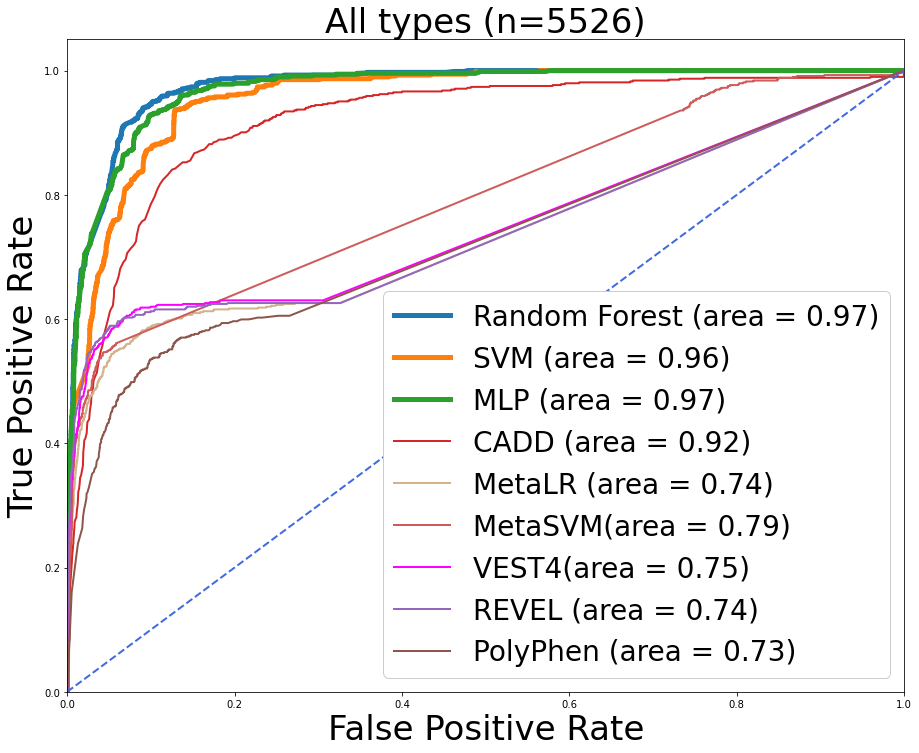

In [59]:
# Creation of ROC plots 
score_RF_ex=clf_RF.predict_proba(X_ex)
score_RF_ex
fpr_RF_ex, tpr_RF_ex, threshs = metrics.roc_curve(y_ex,score_RF_ex[:,1])
roc_auc_RF_ex= auc(fpr_RF_ex, tpr_RF_ex)
tablesRoc(tpr_RF_ex,fpr_RF_ex,threshs,'RF_ex')

score_SVM_ex=svm_modelo.predict_proba(X_ex)
score_SVM_ex
fpr_SVM_ex, tpr_SVM_ex, threshs = metrics.roc_curve(y_ex,score_SVM_ex[:,1])
roc_auc_SVM_ex= auc(fpr_SVM_ex, tpr_SVM_ex)
tablesRoc(tpr_SVM_ex,fpr_SVM_ex,threshs,'SVM_ex')

red_probas_ex = red_modelo.predict_proba(X_ex)
fpr_MLP_ex, tpr_MLP_ex, thresholds = metrics.roc_curve(y_ex, red_probas_ex)
roc_auc_mlp_ex= auc(fpr_MLP_ex, tpr_MLP_ex)
tablesRoc(tpr_MLP_ex,fpr_MLP_ex,threshs,'MLP_ex')

plt.close('all')

plt.figure(figsize=(15, 12))
lw = 2

plt.plot(fpr_RF_ex,tpr_RF_ex,
         lw=5, label='Random Forest (area = %0.2f)' % roc_auc_RF_ex)
plt.plot(fpr_SVM_ex,tpr_SVM_ex,
         lw=5, label='SVM (area = %0.2f)' % roc_auc_SVM_ex)
plt.plot(fpr_MLP_ex, tpr_MLP_ex, 
         lw=5, label='MLP (area = %0.2f)' % roc_auc_mlp_ex)
#plt.plot(fpr_dt_ex, tpr_dt_ex, color='peru', 
#        lw=5, label='Decision Tree (area = %0.2f)' % roc_auc_dt_ex)
#plt.plot(fpr_nb_ex, tpr_nb_ex, color='gray', 
#        lw=5, label='Naive Bayes(area = %0.2f)' % roc_auc_nb_ex)
plt.plot(values_CADD['fpr'], values_CADD['tpr'], 
         lw=lw, label='CADD (area = %0.2f)' % values_CADD['roc_auc'])
tablesRoc(values_CADD['tpr'],values_CADD['fpr'],values_CADD['threshs'],'CADD_all_ex')

#LRT_area = 1-values_LRT['roc_auc']
#plt.plot(1-values_LRT['fpr'],1- values_LRT['tpr'], color='cadetblue',
#         lw=lw, label='LRT (area = %0.2f)' % LRT_area)
#plt.plot(values_MCAP['fpr'], values_MCAP['tpr'], color='sandybrown',
#         lw=lw, label='M-CAP (area = %0.2f)' % values_MCAP['roc_auc'])
#plt.plot(values_Eigen['fpr'], values_Eigen['tpr'], color='teal',
#         lw=lw, label='Eigen (area = %0.2f)' % values_Eigen['roc_auc'])
plt.plot(values_MetaLR['fpr'], values_MetaLR['tpr'], color='tan',
         lw=lw, label='MetaLR (area = %0.2f)' % values_MetaLR['roc_auc'])
tablesRoc(values_MetaLR['tpr'],values_MetaLR['fpr'],values_MetaLR['threshs'],'MetaLR_all_ex')

plt.plot(values_MetaSVM['fpr'], values_MetaSVM['tpr'], color='indianred',
         lw=lw, label='MetaSVM(area = %0.2f)' % values_MetaSVM['roc_auc'])
tablesRoc(values_MetaSVM['tpr'],values_MetaSVM['fpr'],values_MetaSVM['threshs'],'MetaSVM_all_ex')

plt.plot(values_VEST4_score['fpr'], values_VEST4_score['tpr'], color='fuchsia',
         lw=lw, label='VEST4(area = %0.2f)' % values_VEST4_score['roc_auc'])
tablesRoc(values_VEST4_score['tpr'],values_VEST4_score['fpr'],values_VEST4_score['threshs'],'VEST4_all_ex')

plt.plot(values_Revel['fpr'], values_Revel['tpr'], 
         lw=lw, label='REVEL (area = %0.2f)' % values_Revel['roc_auc'])
tablesRoc(values_Revel['tpr'],values_Revel['fpr'],values_Revel['threshs'],'Revel_all_ex')


#plt.plot(values['fpr'], values['tpr'], 
#         lw=lw, label='PON P2 (area = %0.2f)' % values['roc_auc'])
#tablesRoc(values['tpr'],values['fpr'],values['threshs'],'PONP2_all_ex')

#SIFT_area = 1-values_Sift['roc_auc']
#plt.plot(values_Sift['tpr'], values_Sift['fpr'], color='navy',
#         lw=lw, label='SIFT (area = %0.2f)' % SIFT_area)
plt.plot(values_PolyPhen['fpr'], values_PolyPhen['tpr'], 
         lw=lw, label='PolyPhen (area = %0.2f)' % values_PolyPhen['roc_auc'])
tablesRoc(values_PolyPhen['tpr'],values_PolyPhen['fpr'],values_PolyPhen['threshs'],'PolyPhen_all_ex')




plt.plot([0, 1], [0, 1], color='royalblue', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=34)
plt.ylabel('True Positive Rate',fontsize=34)
plt.title('All types (n=5526)',fontsize=34)
plt.legend(fontsize=28,framealpha=1,frameon=1)

In [60]:
#Processing of ex vus information from prediciton tools
set_ex_all_tools = splitCodonDeg (set_ex_all)
set_ex_all_dummies_tools =pd.get_dummies(set_ex_all_tools,columns=['Consequence'])

In [61]:
# Function to filter relevant columns
def filterColumns(df):
    df = df.filter(['APPRIS','BLOSUM62', 'CADD_PHRED', 'CADD_RAW',
       'CADD_phred',  'CLINSIG', 'DANN_score', 'Eigen-pred_coding',
       'FATHMM_score',  'GERP++_RS', 'LINSIGHT', 'LRT_score',
       'LoFtool','M-CAP_score', 'MANE', 'MPC_score', 'MVP_score', 'MaxEntScan_alt',
       'MaxEntScan_diff', 'MaxEntScan_ref', 'MetaLR_score', 'MetaSVM_score',
       'MutPred_score',  'MutationTaster_score', 'MutationAssessor_score',
       'PROVEAN_score', 'PolyPhen',  'REVEL_score', 'SIFT', 
       'TSL', 'VEST4_score', 'ada_score'])
    return df

In [62]:
#Function to process relevant columns
def process (df):
    df = filterColumns(df)
    df['MutationAssessor_score'] = df['MutationAssessor_score'].str.split(',').str[0]
    df['MutationTaster_score'] = df['MutationTaster_score'].str.split(',').str[0]
    df['PROVEAN_score'] = df['PROVEAN_score'].str.split(',').str[0]
    df['VEST4_score'] = df['VEST4_score'].str.split(',').str[0]
    df['FATHMM_score'] = df['FATHMM_score'].str.split(',').str[0]
    df['GERP++_RS'] = df['GERP++_RS'].str.split(',').str[0]
    df['MPC_score'] = df['MPC_score'].str.split(',').str[0]
    df['MVP_score'] = df['MVP_score'].str.split(',').str[0]
    df = fillAll(df)
    df = completeColumns(df)
    df.head()
    X = df.astype (float)
    y = df['CLINSIG'].astype(float)
    scaler = MinMaxScaler(feature_range=(0, 1), copy=True)
    scaler.fit (X)
    return [X,y]

In [63]:
#Function to process dataset to test model
def processModel(df):
    df = df.filter(['ada_score','AF','BLOSUM62','codon_degeneracy','Eigen-pred_coding','GERP++_RS', 
              'integrated_fitCons_score','LoFtool','phyloP100way_vertebrate','SIFT', 'Consequence_5_prime_UTR_variant',
              'Consequence_downstream_gene_variant', 'Consequence_frameshift_variant',
              'Consequence_inframe_deletion', 'Consequence_inframe_insertion',
              'Consequence_intron_variant', 'Consequence_missense_variant',
              'Consequence_non_coding_transcript_exon_variant',
              'Consequence_splice_donor_variant', 'Consequence_splice_region_variant',
              'Consequence_start_lost', 'Consequence_stop_gained',
              'Consequence_synonymous_variant', 'Consequence_upstream_gene_variant',
              'Consequence_intergenic_variant'])
    df = df.replace({'ada_score': "-", 'AF': "-", 'Eigen-pred_coding': '-',
               'integrated_fitCons_score': '-', 'LoFtool': '-', 'phyloP100way_vertebrate':'-',
               'SIFT': '-'}, -1)
    df = df.replace({'BLOSUM62':"-", 'GERP++_RS':'-'}, 0)
    #df['codon_degeneracy'] = df['codon_degeneracy'].str.split(',').str[0]
    df = df.replace({'codon_degeneracy':'-'},0)
    df = completeColumns(df)
    df = df.astype(float)
    scaler = MinMaxScaler(feature_range=(0, 1), copy=True)
    scaler.fit (df)
    return df

    

In [64]:
##Creation of subsets of different data types

#Missense variants
set_ex_miss = set_ex_all_dummies_tools[set_ex_all_dummies_tools['Consequence_missense_variant']==1]
X_miss = process(set_ex_miss)[0]
miss =  processModel(set_ex_miss)
miss = completeColumns(miss)
y_miss = process(set_ex_miss)[1]

##Synonymous variants
set_ex_syn = set_ex_all_dummies_tools[set_ex_all_dummies_tools['Consequence_synonymous_variant']==1]
X_syn= process(set_ex_syn)[0]
syn =  processModel(set_ex_syn)
syn = completeColumns(syn)
y_syn = process(set_ex_syn)[1]

#Non coding exon variants
set_ex_nce = set_ex_all_dummies_tools[set_ex_all_dummies_tools['Consequence_non_coding_transcript_exon_variant']==1]
X_nce= process(set_ex_nce)[0]
nce =  processModel(set_ex_nce)
nce = completeColumns(nce)
y_nce = process(set_ex_nce)[1]

#Intron type variants
set_ex_int = set_ex_all_dummies_tools[set_ex_all_dummies_tools['Consequence_intron_variant']==1]
X_int= process(set_ex_int)[0]
vint =  processModel(set_ex_int)
vint = completeColumns (vint)
y_int = process(set_ex_int)[1]

#Splice variants 
set_ex_spl = set_ex_all_dummies_tools[(set_ex_all_dummies_tools['Consequence_splice_donor_variant']==1)
                                     | (set_ex_all_dummies_tools['Consequence_splice_region_variant']==1)]
X_spl= process(set_ex_spl)[0]
spl =  processModel(set_ex_spl)
spl = completeColumns(spl)
y_spl = process(set_ex_spl)[1]

#Other variant types
set_ex_oth =  set_ex_all_dummies_tools[(set_ex_all_dummies_tools['Consequence_splice_donor_variant']!=1)
                                     & (set_ex_all_dummies_tools['Consequence_splice_region_variant']!=1)
                                     & (set_ex_all_dummies_tools['Consequence_missense_variant']!=1)
                                     & (set_ex_all_dummies_tools['Consequence_synonymous_variant']!=1)  
                                     & (set_ex_all_dummies_tools['Consequence_non_coding_transcript_exon_variant']!=1)
                                     & (set_ex_all_dummies_tools['Consequence_intron_variant']!=1)
                                     & (set_ex_all_dummies_tools['Consequence_frameshift_variant']!=1)
                                     & (set_ex_all_dummies_tools['Consequence_inframe_deletion']!=1)
                                     & (set_ex_all_dummies_tools['Consequence_inframe_insertion']!=1)
                                     & (set_ex_all_dummies_tools['Consequence_intergenic_variant']!=1)]

X_oth= process(set_ex_oth)[0]
oth =  processModel(set_ex_oth)
oth = completeColumns(oth)
y_oth = process(set_ex_oth)[1]

#Insertion or deletion variants
set_ex_indl = set_ex_all_dummies_tools[(set_ex_all_dummies_tools['Consequence_frameshift_variant']==1)
                                      | (set_ex_all_dummies_tools['Consequence_inframe_deletion']==1)
                                      | (set_ex_all_dummies_tools['Consequence_inframe_insertion']==1)]
X_indl= process(set_ex_indl)[0]
indl =  processModel(set_ex_indl)
indl = completeColumns(indl)
y_indl = process(set_ex_indl)[1]

#Intergenic region variants
set_ex_ign = set_ex_all_dummies_tools[(set_ex_all_dummies_tools['Consequence_intergenic_variant']==1)]
X_ign= process(set_ex_ign)[0]
ign =  processModel(set_ex_ign)
ign = completeColumns(ign)
y_ign = process(set_ex_ign)[1]

In [65]:
#Create ROC values for specific type of variants
def carlROC_specific(X,y,column):
    fpr, tpr, threshs= metrics.roc_curve(y,X[column])
    roc_auc= auc(fpr, tpr)
    values = {'roc_auc': roc_auc, 'fpr': fpr, 'tpr': tpr, 'threshs': threshs}
    return values

In [66]:
def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value
        
    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 

In [67]:
def fullMetrics(tool,X,y,variantType):
    print(variantType)
    df=pd.DataFrame()
    
    lst_dict=[]
    for column in X.columns:
        print ("\n"+column )
        
        cutoff = Find_Optimal_Cutoff(y,X[column])
        print ('ROC threshold cutoff: ' + str(cutoff))
        output = np.zeros((len(X[column].values),1))

        for i in range(len(X[column].values)):
            if X[column].values[i] >= cutoff:
                output[i] = 1
            else:
                output[i] = 0
                
        lst_dict.append({'Name':column, 'TN':confusion_matrix(y,output)[0][0], 
                         'TP': confusion_matrix(y,output)[1][1],
                         'FN': confusion_matrix(y,output)[1][0],
                         'FP': confusion_matrix(y,output)[0][1],
                         'Sensitivity': recall_score(y,output),
                         'Specificity': confusion_matrix(y,output)[0][0] / (confusion_matrix(y,output)[0][0] + confusion_matrix(y,output)[0][1]),
                         'Accuracy': accuracy_score(y,output),
                         'Precision': precision_score(y,output),
                         'F1-Score': f1_score(y,output),
                         'PositivePredictiveValue': confusion_matrix(y,output)[1][1] / ( confusion_matrix(y,output)[1][1] + confusion_matrix(y,output)[0][1] ),
                         'NegativePredictiveValue': confusion_matrix(y,output)[0][0] / ( confusion_matrix(y,output)[0][0] + confusion_matrix(y,output)[1][0] ),
                         'MatthewsCorrelation': matthews_corrcoef(y,output),
                         'LogLoss': log_loss(y,output),
                        })
                
    score_RF=clf_RF.predict(tool)
    score_SVM=svm_modelo.predict(tool)
    red_probas = red_modelo.predict_classes(tool)
    modelos = [[score_RF,'RandomForest'],[score_SVM,'SupportVectorMachine'],[red_probas,'MultilayerPerceptron']]

    for modelo in modelos:
        output=modelo[0]
        lst_dict.append({'Name':modelo[1], 'TN':confusion_matrix(y,output)[0][0], 
                         'TP': confusion_matrix(y,output)[1][1],
                         'FN': confusion_matrix(y,output)[1][0],
                         'FP': confusion_matrix(y,output)[0][1],
                         'Sensitivity': recall_score(y,output),
                         'Specificity': confusion_matrix(y,output)[0][0] / (confusion_matrix(y,output)[0][0] + confusion_matrix(y,output)[0][1]),
                         'Accuracy': accuracy_score(y,output),
                         'Precision': precision_score(y,output),
                         'F1-Score': f1_score(y,output),
                         'PositivePredictiveValue': confusion_matrix(y,output)[1][1] / ( confusion_matrix(y,output)[1][1] + confusion_matrix(y,output)[0][1] ),
                         'NegativePredictiveValue': confusion_matrix(y,output)[0][0] / ( confusion_matrix(y,output)[0][0] + confusion_matrix(y,output)[1][0] ),
                         'MatthewsCorrelation': matthews_corrcoef(y,output),
                         'LogLoss': log_loss(y,output),
                        })

    df = df.append(lst_dict)   
    df.to_csv(r'metrics_'+variantType+'.csv',index=False)
    return df

In [70]:
def plotValues(tool, X,y,consType,num):
    #score_nb=clf_nb.predict_proba(tool)
    #fpr_nb, tpr_nb, threshs = metrics.roc_curve(y,score_nb[:,1])
    #roc_auc_nb= auc(fpr_nb, tpr_nb)

    #score_dt=clf_dt.predict_proba(tool)
    #fpr_dt, tpr_dt, threshs = metrics.roc_curve(y,score_dt[:,1])
    #roc_auc_dt= auc(fpr_dt, tpr_dt)

    score_RF=clf_RF.predict_proba(tool)
    score_RF
    fpr_RF, tpr_RF, threshs = metrics.roc_curve(y,score_RF[:,1])
    roc_auc_RF= auc(fpr_RF, tpr_RF)
    #tablesRoc(tpr_RF,fpr_RF,threshs,tool+consType+'RF')

    score_SVM=svm_modelo.predict_proba(tool)
    score_SVM
    fpr_SVM, tpr_SVM, threshs = metrics.roc_curve(y,score_SVM[:,1])
    roc_auc_SVM= auc(fpr_SVM, tpr_SVM)
   # tablesRoc(tpr_SVM,fpr_SVM,threshs,tool+consType+'SVM')

    red_probas = red_modelo.predict_proba(tool)
    fpr_MLP, tpr_MLP, thresholds = metrics.roc_curve(y, red_probas)
    roc_auc_mlp= auc(fpr_MLP, tpr_MLP)
    #tablesRoc(tpr_MLP,fpr_MLP,threshs,tool+consType+'MLP')
   
    
    plt.close('all')
    plt.figure(figsize=(15, 12))
    #plt.style.use('seaborn-paper')
    lw = 2
    plt.plot(fpr_RF,tpr_RF, 
             lw=5, label='Random Forest (area = %0.2f)' % roc_auc_RF)
    plt.plot(fpr_SVM,tpr_SVM, 
             lw=5, label='SVM (area = %0.2f)' % roc_auc_SVM)
    plt.plot(fpr_MLP, tpr_MLP, 
             lw=5, label='MLP (area = %0.2f)' % roc_auc_mlp)
    #plt.plot(fpr_dt, tpr_dt, color='peru', 
            #lw=5, label='Decision Tree (area = %0.2f)' % roc_auc_dt)
    #plt.plot(fpr_nb, tpr_nb, color='gray', 
            #lw=5, label='Naive Bayes(area = %0.2f)' % roc_auc_nb)
    
    
    #plt.plot(carlROC_specific(X,y,'APPRIS')['fpr'], carlROC_specific(X,y,'APPRIS')['tpr'] , color='olive', lw=lw, label='APPRIS, (area = %0.2f)' % carlROC_specific(X,y,'APPRIS')['roc_auc'])

    #plt.plot(carlROC_specific(X,y,'BLOSUM62')['fpr'], carlROC_specific(X,y,'BLOSUM62')['tpr'] , color='olive', lw=lw, linestyle="--", label='BLOSUM62, (area = %0.2f)' % carlROC_specific(X,y,'BLOSUM62')['roc_auc'])

    plt.plot(carlROC_specific(X,y,'CADD_PHRED')['fpr'], carlROC_specific(X,y,'CADD_PHRED')['tpr'] , label='CADD (area = %0.2f)' % carlROC_specific(X,y,'CADD_PHRED')['roc_auc'])
   
    #plt.plot(carlROC_specific(X,y,'CADD_RAW')['fpr'], carlROC_specific(X,y,'CADD_RAW')['tpr'] , color='teal', lw=lw, linestyle="--",label='CADD_RAW, (area = %0.2f)' % carlROC_specific(X,y,'CADD_RAW')['roc_auc']) 

    #plt.plot(carlROC_specific(X,y,'CADD_phred')['fpr'], carlROC_specific(X,y,'CADD_phred')['tpr'] , color='tan', lw=lw, label='CADD_phred, (area = %0.2f)' % carlROC_specific(X,y,'CADD_phred')['roc_auc'])

    #plt.plot(carlROC_specific(X,y,'CLINSIG')['fpr'], carlROC_specific(X,y,'CLINSIG')['tpr'] , color='tan', lw=lw,linestyle="--", label='CLINSIG, (area = %0.2f)' % carlROC_specific(X,y,'CLINSIG')['roc_auc'])

    #plt.plot(carlROC_specific(X,y,'DANN_score')['fpr'], carlROC_specific(X,y,'DANN_score')['tpr'] , color='indianred', lw=lw, label='DANN_score, (area = %0.2f)' % carlROC_specific(X,y,'DANN_score')['roc_auc'])

    #plt.plot(carlROC_specific(X,y,'Eigen-pred_coding')['fpr'], carlROC_specific(X,y,'Eigen-pred_coding')['tpr'] , lw=lw, label='Eigen (area = %0.2f)' % carlROC_specific(X,y,'Eigen-pred_coding')['roc_auc'])

    #plt.plot(carlROC_specific(X,y,'FATHMM_score')['fpr'], carlROC_specific(X,y,'FATHMM_score')['tpr'] , color='orangered', lw=lw, label='FATHMM_score, (area = %0.2f)' % carlROC_specific(X,y,'FATHMM_score')['roc_auc'])

    #plt.plot(carlROC_specific(X,y,'GERP++_RS')['fpr'], carlROC_specific(X,y,'GERP++_RS')['tpr'] , color='orangered', lw=lw, linestyle="--",label='GERP++_RS, (area = %0.2f)' % carlROC_specific(X,y,'GERP++_RS')['roc_auc'])

    #plt.plot(carlROC_specific(X,y,'LINSIGHT')['fpr'], carlROC_specific(X,y,'LINSIGHT')['tpr'] , color='saddlebrown', lw=lw, label='LINSIGHT, (area = %0.2f)' % carlROC_specific(X,y,'LINSIGHT')['roc_auc'])

    #plt.plot((1-carlROC_specific(X,y,'LRT_score')['fpr']), (1-carlROC_specific(X,y,'LRT_score')['tpr']) , color='saddlebrown', lw=lw, linestyle="--",label='LRT_score, (area = %0.2f)' % (1-carlROC_specific(X,y,'LRT_score')['roc_auc']))

    #plt.plot(carlROC_specific(X,y,'LoFtool')['fpr'], carlROC_specific(X,y,'LoFtool')['tpr'] , color='orange', lw=lw, label='LoFtool, (area = %0.2f)' % carlROC_specific(X,y,'LoFtool')['roc_auc']) 

    #plt.plot(carlROC_specific(X,y,'M-CAP_score')['fpr'], carlROC_specific(X,y,'M-CAP_score')['tpr'] , lw=lw, label='M-CAP (area = %0.2f)' % carlROC_specific(X,y,'M-CAP_score')['roc_auc'])

    #plt.plot(carlROC_specific(X,y,'MANE')['fpr'], carlROC_specific(X,y,'MANE')['tpr'] , color='gold', lw=lw, label='MANE, (area = %0.2f)' % carlROC_specific(X,y,'MANE')['roc_auc']) 

    #plt.plot(carlROC_specific(X,y,'MPC_score')['fpr'], carlROC_specific(X,y,'MPC_score')['tpr'] , color='gold', lw=lw, linestyle="--",label='MPC_score, (area = %0.2f)' % carlROC_specific(X,y,'MPC_score')['roc_auc']) 

    #plt.plot(carlROC_specific(X,y,'MVP_score')['fpr'], carlROC_specific(X,y,'MVP_score')['tpr'] , color='lawngreen', lw=lw, label='MVP_score, (area = %0.2f)' % carlROC_specific(X,y,'MVP_score')['roc_auc']) 

    #plt.plot(carlROC_specific(X,y,'MaxEntScan_alt')['fpr'], carlROC_specific(X,y,'MaxEntScan_alt')['tpr'] , color='lawngreen', lw=lw, linestyle="--",label='MaxEntScan_alt, (area = %0.2f)' % carlROC_specific(X,y,'MaxEntScan_alt')['roc_auc']) 

    #plt.plot(carlROC_specific(X,y,'MaxEntScan_diff')['fpr'], carlROC_specific(X,y,'MaxEntScan_diff')['tpr'] , lw=lw, label='MaxEntScan_diff, (area = %0.2f)' % carlROC_specific(X,y,'MaxEntScan_diff')['roc_auc']) 

    #plt.plot(carlROC_specific(X,y,'MaxEntScan_ref')['fpr'], carlROC_specific(X,y,'MaxEntScan_ref')['tpr'] , color='palegreen', lw=lw, linestyle="--",label='MaxEntScan_ref, (area = %0.2f)' % carlROC_specific(X,y,'MaxEntScan_ref')['roc_auc']) 

    plt.plot(carlROC_specific(X,y,'MetaLR_score')['fpr'], carlROC_specific(X,y,'MetaLR_score')['tpr'] ,  lw=lw, label='MetaLR, (area = %0.2f)' % carlROC_specific(X,y,'MetaLR_score')['roc_auc']) 

    plt.plot(carlROC_specific(X,y,'MetaSVM_score')['fpr'], carlROC_specific(X,y,'MetaSVM_score')['tpr'] ,  lw=lw, label='MetaSVM, (area = %0.2f)' % carlROC_specific(X,y,'MetaSVM_score')['roc_auc'])

    #plt.plot(carlROC_specific(X,y,'MutPred_score')['fpr'], carlROC_specific(X,y,'MutPred_score')['tpr'] , color='turquoise', lw=lw, label='MutPred_score, (area = %0.2f)' % carlROC_specific(X,y,'MutPred_score')['roc_auc'])

    #plt.plot(carlROC_specific(X,y,'MutationTaster_score')['fpr'], carlROC_specific(X,y,'MutationTaster_score')['tpr'] , color='turquoise', lw=lw, linestyle="--",label='MutationTaster_score, (area = %0.2f)' % carlROC_specific(X,y,'MutationTaster_score')['roc_auc']) 

    #plt.plot(carlROC_specific(X,y,'MutationAssessor_score')['fpr'], carlROC_specific(X,y,'MutationAssessor_score')['tpr'] , color='steelblue', lw=lw, label='MutationAssessor_score, (area = %0.2f)' % carlROC_specific(X,y,'MutationAssessor_score')['roc_auc'])

    #plt.plot(carlROC_specific(X,y,'PROVEAN_score')['fpr'], carlROC_specific(X,y,'PROVEAN_score')['tpr'] , color='steelblue', lw=lw,linestyle="--", label='PROVEAN_score, (area = %0.2f)' % carlROC_specific(X,y,'PROVEAN_score')['roc_auc'])

    #plt.plot(carlROC_specific(X,y,'PolyPhen')['fpr'], carlROC_specific(X,y,'PolyPhen')['tpr'] ,  lw=lw, label='PolyPhen (area = %0.2f)' % carlROC_specific(X,y,'PolyPhen')['roc_auc'])

    #plt.plot(carlROC_specific(X,y,'REVEL_score')['fpr'], carlROC_specific(X,y,'REVEL_score')['tpr'] ,  lw=lw, label='REVEL_score (area = %0.2f)' % carlROC_specific(X,y,'REVEL_score')['roc_auc'])

    #plt.plot((1-carlROC_specific(X,y,'SIFT')['fpr']), (1-carlROC_specific(X,y,'SIFT')['tpr'] ),  lw=lw, label='SIFT (area = %0.2f)' % (1-carlROC_specific(X,y,'SIFT')['roc_auc']))

    #plt.plot(carlROC_specific(X,y,'TSL')['fpr'], carlROC_specific(X,y,'TSL')['tpr'] , color='crimson', lw=lw, linestyle="--",label='TSL, (area = %0.2f)' % carlROC_specific(X,y,'TSL')['roc_auc'])

    plt.plot(carlROC_specific(X,y,'VEST4_score')['fpr'], carlROC_specific(X,y,'VEST4_score')['tpr'] , color='blue', lw=lw, linestyle="--",label='VEST4, (area = %0.2f)' % carlROC_specific(X,y,'VEST4_score')['roc_auc']) 
    plt.plot(values['fpr'], values['tpr'], lw=lw, label='PON P2 (area = %0.2f)' % values['roc_auc'])

    #plt.plot(carlROC_specific(X,y,'ada_score')['fpr'], carlROC_specific(X,y,'ada_score')['tpr'] , lw=lw, label='ada score (area = %0.2f)' % carlROC_specific(X,y,'ada_score')['roc_auc']) 

    #plt.plot([0, 1], [0, 1], color='royalblue', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate',fontsize=36)
    plt.ylabel('True Positive Rate',fontsize=36)
    plt.title('ex-VUS '+consType+ " (n = "+num+")", fontsize=36)
    #plt.legend(fontsize=32,loc=4,facecolor='white', frameon=True, framealpha=1)
    plt.legend(fontsize=32,loc=4)
    

In [71]:
def plotValuesPR(tool, X,y,consType,num):
   #score_nb=clf_nb.predict_proba(tool)
    #precision_nb, recall_nb, threshs = metrics.precision_recall_curve(y,score_nb[:,1])
    #pr_auc_nb= auc(precision_nb, recall_nb)

    #score_dt=clf_dt.predict_proba(tool)
    #precision_dt, recall_dt, threshs = metrics.precision_recall_curve(y,score_dt[:,1])
    #pr_auc_dt= auc(precision_dt, recall_dt)

    score_RF=clf_RF.predict_proba(tool)
    score_RF
    precision_RF, recall_RF, threshs = metrics.precision_recall_curve(y,score_RF[:,1])
    #tablesRoc(recall_RF,precision_RF,threshs,tool+consType+'RF')

    score_SVM=svm_modelo.predict_proba(tool)
    score_SVM
    precision_SVM, recall_SVM, threshs = metrics.precision_recall_curve(y,score_SVM[:,1])
   # tablesRoc(recall_SVM,precision_SVM,threshs,tool+consType+'SVM')

    red_probas = red_modelo.predict_proba(tool)
    precision_MLP, recall_MLP, thresholds = metrics.precision_recall_curve(y, red_probas)
    #tablesRoc(recall_MLP,precision_MLP,threshs,tool+consType+'MLP')
   
    
    plt.close('all')
    plt.figure(figsize=(15, 12))
    #plt.style.use('seaborn-paper')
    lw = 2
    plt.plot(precision_RF,recall_RF, 
             lw=5, label='Random Forest (area = %0.2f)' )
    plt.plot(precision_SVM,recall_SVM, 
             lw=5, label='SVM (area = %0.2f)' )
    plt.plot(precision_MLP, recall_MLP, 
             lw=5, label='MLP (area = %0.2f)' )
   
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Precision',fontsize=36)
    plt.ylabel('Recall',fontsize=36)
    plt.title('ex-VUS '+consType+ " (n = "+num+")", fontsize=36)
    #plt.legend(fontsize=32,loc=4,facecolor='white', frameon=True, framealpha=1)
    plt.legend(fontsize=32,loc=4)

In [72]:
def createTables(X,y,consType):
    tablesRoc( carlROC_specific(X,y,'CADD_PHRED')['tpr'] , carlROC_specific(X,y,'CADD_PHRED')['fpr'] , carlROC_specific(X,y,'CADD_PHRED')['threshs'] , consType+'_CADD')
    tablesRoc(carlROC_specific(X,y,'MetaLR_score')['tpr'],carlROC_specific(X,y,'MetaLR_score')['fpr'],carlROC_specific(X,y,'MetaLR_score')['threshs'],consType+'MetaLR_score')
    tablesRoc(carlROC_specific(X,y,'MetaSVM_score')['tpr'],carlROC_specific(X,y,'MetaSVM_score')['fpr'],carlROC_specific(X,y,'MetaSVM_score')['threshs'],consType+'MetaSVM_score')
    tablesRoc(carlROC_specific(X,y,'VEST4_score')['tpr'],carlROC_specific(X,y,'VEST4_score')['fpr'],carlROC_specific(X,y,'VEST4_score')['threshs'],consType+'VEST4_score')


In [73]:
#Function to print AUC values for the different subsets
def printAUC(tool, X,y,consType):
    score_RF=clf_RF.predict_proba(tool)
    score_RF
    fpr_RF, tpr_RF, threshs = metrics.roc_curve(y,score_RF[:,1])
    roc_auc_RF= auc(fpr_RF, tpr_RF)

    score_SVM=svm_modelo.predict_proba(tool)
    score_SVM
    fpr_SVM, tpr_SVM, threshs = metrics.roc_curve(y,score_SVM[:,1])
    roc_auc_SVM= auc(fpr_SVM, tpr_SVM)

    red_probas = red_modelo.predict_proba(tool)
    fpr_MLP, tpr_MLP, thresholds = metrics.roc_curve(y, red_probas)
    roc_auc_mlp= auc(fpr_MLP, tpr_MLP)
    print(consType, "RF: ", roc_auc_RF, " SVM: ", roc_auc_SVM, " MLP: ", roc_auc_mlp )

In [69]:
# Printing AUC values from the different subsets
printAUC(vint, X_int,y_int,'intron type')
printAUC(miss, X_miss,y_miss,'missense')
printAUC(nce, X_nce,y_nce,'non coding mRNA')
printAUC(syn, X_syn, y_syn, 'synonymous')
printAUC(oth, X_oth, y_oth, 'other types')
printAUC(spl, X_spl, y_spl, ' splice variants')
printAUC(indl, X_indl, y_indl, ' coding INDELs')
printAUC(ign, X_ign, y_ign, 'intergenic')

intron type RF:  0.8811188811188813  SVM:  0.835933297471759  MLP:  0.8784292630446475
missense RF:  0.9674373285318509  SVM:  0.9600195771163266  MLP:  0.9610732690042462
non coding mRNA RF:  0.8947784029217254  SVM:  0.8515941170664297  MLP:  0.8570723521863588
synonymous RF:  0.9007785623755206  SVM:  0.8892811877602752  MLP:  0.8976099945681695
other types RF:  0.9127938914524281  SVM:  0.9200999780268072  MLP:  0.8893100417490662
 splice variants RF:  0.9688301282051281  SVM:  0.9087339743589742  MLP:  0.9546207264957265
 coding INDELs RF:  0.27325581395348836  SVM:  0.5447227191413238  MLP:  0.22719141323792486
intergenic RF:  0.5761904761904761  SVM:  0.5761904761904761  MLP:  0.5863354037267081


# Plotting Values from the different subsets

## INTRON

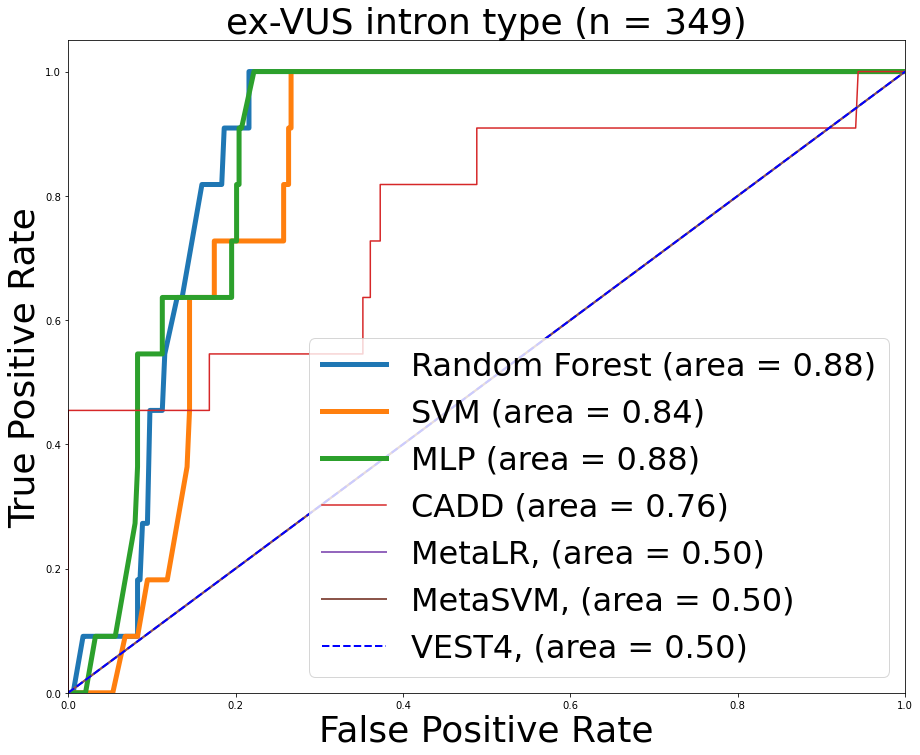

In [171]:
plotValues(vint, X_int,y_int,'intron type','349')

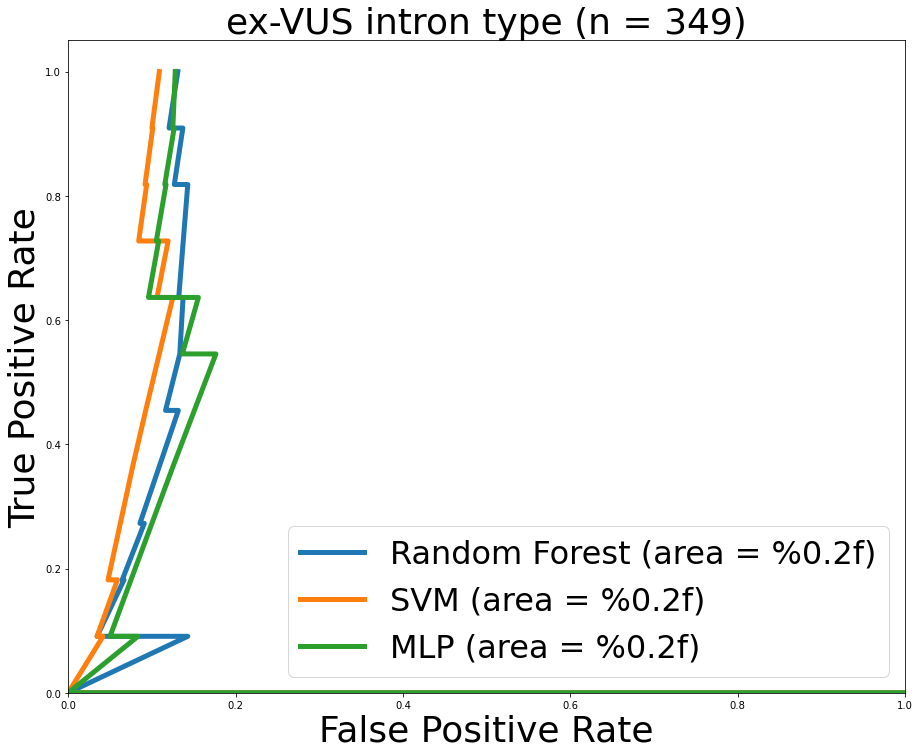

In [150]:
plotValuesPR(vint, X_int,y_int,'intron type','349')

In [97]:
createTables(X_int,y_int,'intron type')

In [231]:
fullMetrics(vint,X_int,y_int,'intron type')

intron type

APPRIS
ROC threshold cutoff: [1.0]

BLOSUM62
ROC threshold cutoff: [1.0]

CADD_PHRED
ROC threshold cutoff: [8.406]

CADD_RAW
ROC threshold cutoff: [0.625211]

CADD_phred
ROC threshold cutoff: [1.0]

CLINSIG
ROC threshold cutoff: [1.0]

DANN_score
ROC threshold cutoff: [1.0]

Eigen-pred_coding
ROC threshold cutoff: [1.0]

FATHMM_score
ROC threshold cutoff: [1.0]

GERP++_RS
ROC threshold cutoff: [1.0]

LINSIGHT
ROC threshold cutoff: [1.0]

LRT_score
ROC threshold cutoff: [1.0]

LoFtool
ROC threshold cutoff: [0.0621]

M-CAP_score
ROC threshold cutoff: [1.0]

MANE
ROC threshold cutoff: [1.0]

MPC_score


/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-230-d3134d5e1bef>:28: RuntimeWarning: invalid value encountered in long_scalars
  'PositivePredictiveValue': confusion_matrix(y,output)[1][1] / ( confusion_matrix(y,output)[1][1] + confusion_matrix(y,output)[0][1] ),
/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter t

ROC threshold cutoff: [1.0]

MVP_score
ROC threshold cutoff: [1.0]

MaxEntScan_alt
ROC threshold cutoff: [0.72]

MaxEntScan_diff
ROC threshold cutoff: [0.051]

MaxEntScan_ref
ROC threshold cutoff: [2.076]

MetaLR_score
ROC threshold cutoff: [1.0]

MetaSVM_score
ROC threshold cutoff: [1.0]

MutPred_score
ROC threshold cutoff: [1.0]

MutationTaster_score
ROC threshold cutoff: [1.0]

MutationAssessor_score
ROC threshold cutoff: [1.0]

PROVEAN_score
ROC threshold cutoff: [1.0]

PolyPhen
ROC threshold cutoff: [1.0]

REVEL_score
ROC threshold cutoff: [1.0]

SIFT
ROC threshold cutoff: [1.0]


/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-230-d3134d5e1bef>:28: RuntimeWarning: invalid value encountered in long_scalars
  'PositivePredictiveValue': confusion_matrix(y,output)[1][1] / ( confusion_matrix(y,output)[1][1] + confusion_matrix(y,output)[0][1] ),
/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter t


TSL
ROC threshold cutoff: [1.0]

VEST4_score
ROC threshold cutoff: [1.0]

ada_score
ROC threshold cutoff: [7.13320835762278e-06]

Consequence_3_prime_UTR_variant
ROC threshold cutoff: [1.0]

Consequence_5_prime_UTR_variant
ROC threshold cutoff: [1.0]

Consequence_TF_binding_site_variant
ROC threshold cutoff: [1.0]

Consequence_downstream_gene_variant
ROC threshold cutoff: [1.0]

Consequence_frameshift_variant
ROC threshold cutoff: [1.0]

Consequence_inframe_deletion
ROC threshold cutoff: [1.0]

Consequence_inframe_insertion
ROC threshold cutoff: [1.0]

Consequence_intergenic_variant
ROC threshold cutoff: [1.0]

Consequence_intron_variant
ROC threshold cutoff: [1.0]

Consequence_missense_variant
ROC threshold cutoff: [1.0]

Consequence_non_coding_transcript_exon_variant
ROC threshold cutoff: [1.0]

Consequence_protein_altering_variant
ROC threshold cutoff: [1.0]

Consequence_regulatory_region_variant
ROC threshold cutoff: [1.0]


/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-230-d3134d5e1bef>:28: RuntimeWarning: invalid value encountered in long_scalars
  'PositivePredictiveValue': confusion_matrix(y,output)[1][1] / ( confusion_matrix(y,output)[1][1] + confusion_matrix(y,output)[0][1] ),
/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter t

/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-230-d3134d5e1bef>:28: RuntimeWarning: invalid value encountered in long_scalars
  'PositivePredictiveValue': confusion_matrix(y,output)[1][1] / ( confusion_matrix(y,output)[1][1] + confusion_matrix(y,output)[0][1] ),
/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/bioinformatic/ana


Consequence_splice_acceptor_variant
ROC threshold cutoff: [1.0]

Consequence_splice_donor_variant
ROC threshold cutoff: [1.0]

Consequence_splice_region_variant
ROC threshold cutoff: [1.0]

Consequence_start_lost
ROC threshold cutoff: [1.0]

Consequence_stop_gained
ROC threshold cutoff: [1.0]

Consequence_stop_lost
ROC threshold cutoff: [1.0]

Consequence_stop_retained_variant
ROC threshold cutoff: [1.0]

Consequence_synonymous_variant
ROC threshold cutoff: [1.0]

Consequence_upstream_gene_variant
ROC threshold cutoff: [1.0]


,Name,TN,TP,FN,FP,Sensitivity,Specificity,Accuracy,Precision,F1-Score,PositivePredictiveValue,NegativePredictiveValue,MatthewsCorrelation,LogLoss
0,APPRIS,338,0,11,0,0.000000,1.000000,0.968481,0.000000,0.000000,NaN,0.968481,0.000000,1.088615e+00
1,BLOSUM62,338,0,11,0,0.000000,1.000000,0.968481,0.000000,0.000000,NaN,0.968481,0.000000,1.088615e+00
2,CADD_PHRED,216,7,4,122,0.636364,0.639053,0.638968,0.054264,0.100000,0.054264,0.981818,0.099687,1.246987e+01
3,CADD_RAW,216,7,4,122,0.636364,0.639053,0.638968,0.054264,0.100000,0.054264,0.981818,0.099687,1.246987e+01
4,CADD_phred,338,0,11,0,0.000000,1.000000,0.968481,0.000000,0.000000,NaN,0.968481,0.000000,1.088615e+00
5,CLINSIG,338,11,0,0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9.992007e-16
6,DANN_score,338,0,11,0,0.000000,1.000000,0.968481,0.000000,0.000000,NaN,0.968481,0.000000,1.088615e+00
7,Eigen-pred_coding,338,0,11,0,0.000000,1.000000,0.968481,0.000000,0.000000,NaN,0.968481,0.000000,1.088615e+00
8,FATHMM_score,338,0,11,0,0.000000,1.000000,0.968481,0.000000,0.000000,NaN,0.968481,0.000000,1.088615e+00
9,GERP++_RS,338,0,11,0,0.000000,1.000000,0.968481,0.000000,0.000000,NaN,0.968481,0.000000,1.088615e+00


## Missense

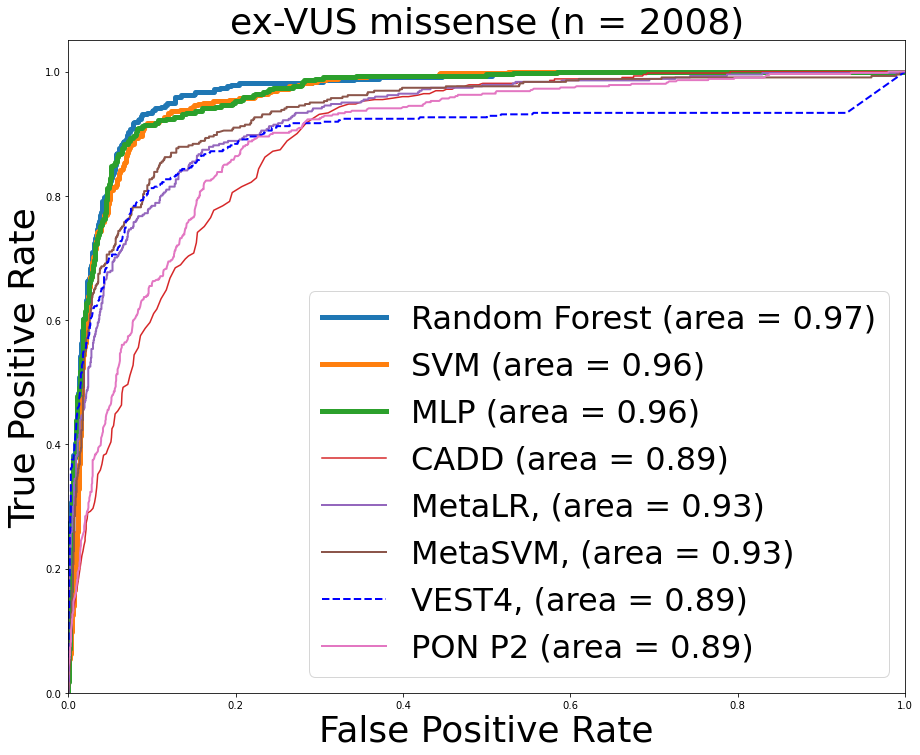

In [74]:
plotValues(miss, X_miss,y_miss,'missense','2008')

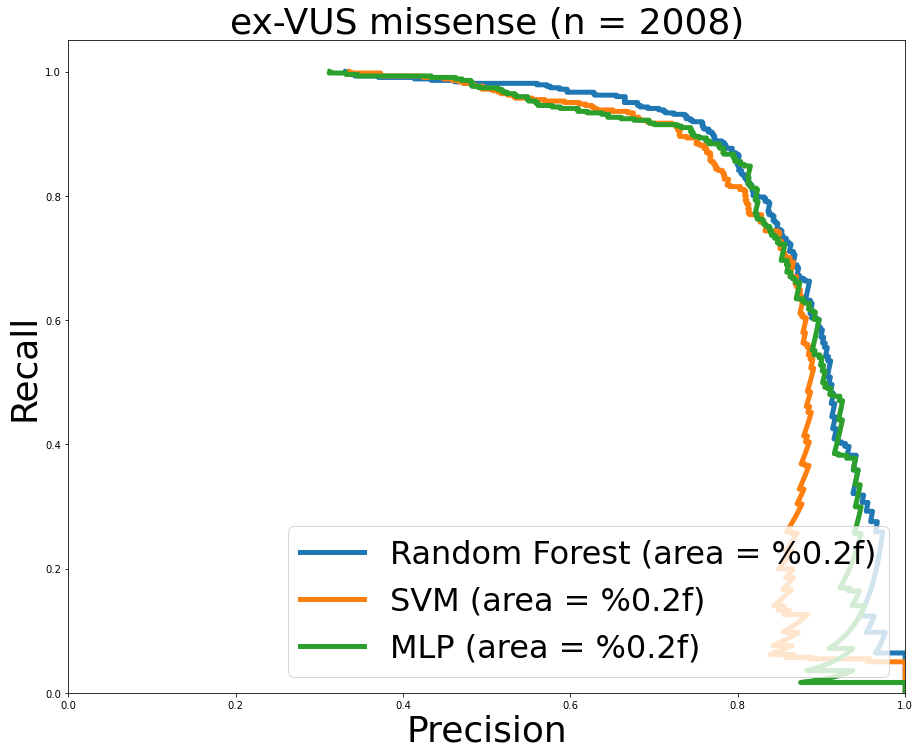

In [75]:
plotValuesPR(miss, X_miss,y_miss,'missense','2008')

In [90]:
createTables(X_miss,y_miss,'missense')

In [232]:
fullMetrics(miss, X_miss,y_miss,'missense')

missense

APPRIS
ROC threshold cutoff: [1.0]

BLOSUM62
ROC threshold cutoff: [0.0]

CADD_PHRED
ROC threshold cutoff: [24.6]

CADD_RAW
ROC threshold cutoff: [3.631607]

CADD_phred
ROC threshold cutoff: [24.7]

CLINSIG
ROC threshold cutoff: [1.0]


/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-230-d3134d5e1bef>:28: RuntimeWarning: invalid value encountered in long_scalars
  'PositivePredictiveValue': confusion_matrix(y,output)[1][1] / ( confusion_matrix(y,output)[1][1] + confusion_matrix(y,output)[0][1] ),
/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)



DANN_score
ROC threshold cutoff: [0.9963317215521436]

Eigen-pred_coding
ROC threshold cutoff: [4.572077]

FATHMM_score
ROC threshold cutoff: [-1.5]

GERP++_RS
ROC threshold cutoff: [4.73]

LINSIGHT
ROC threshold cutoff: [0.0652958]

LRT_score
ROC threshold cutoff: [6e-06]

LoFtool
ROC threshold cutoff: [0.0899]

M-CAP_score
ROC threshold cutoff: [0.188852]

MANE
ROC threshold cutoff: [1.0]

MPC_score
ROC threshold cutoff: [0.110639514685]

MVP_score
ROC threshold cutoff: [0.88629211834]

MaxEntScan_alt
ROC threshold cutoff: [0.29]


/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-230-d3134d5e1bef>:28: RuntimeWarning: invalid value encountered in long_scalars
  'PositivePredictiveValue': confusion_matrix(y,output)[1][1] / ( confusion_matrix(y,output)[1][1] + confusion_matrix(y,output)[0][1] ),
/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)



MaxEntScan_diff
ROC threshold cutoff: [0.05]

MaxEntScan_ref
ROC threshold cutoff: [3.104]

MetaLR_score
ROC threshold cutoff: [0.6203]

MetaSVM_score
ROC threshold cutoff: [0.2064]

MutPred_score
ROC threshold cutoff: [0.057]

MutationTaster_score
ROC threshold cutoff: [1.0]

MutationAssessor_score
ROC threshold cutoff: [1.505]

PROVEAN_score
ROC threshold cutoff: [-2.45]

PolyPhen
ROC threshold cutoff: [0.806]

REVEL_score
ROC threshold cutoff: [0.587]

SIFT
ROC threshold cutoff: [0.02]

TSL
ROC threshold cutoff: [1.0]


/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-230-d3134d5e1bef>:28: RuntimeWarning: invalid value encountered in long_scalars
  'PositivePredictiveValue': confusion_matrix(y,output)[1][1] / ( confusion_matrix(y,output)[1][1] + confusion_matrix(y,output)[0][1] ),
/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter t


VEST4_score
ROC threshold cutoff: [0.659]

ada_score
ROC threshold cutoff: [8.91234063132726e-06]

Consequence_3_prime_UTR_variant
ROC threshold cutoff: [1.0]

Consequence_5_prime_UTR_variant
ROC threshold cutoff: [1.0]

Consequence_TF_binding_site_variant
ROC threshold cutoff: [1.0]

Consequence_downstream_gene_variant
ROC threshold cutoff: [1.0]


/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-230-d3134d5e1bef>:28: RuntimeWarning: invalid value encountered in long_scalars
  'PositivePredictiveValue': confusion_matrix(y,output)[1][1] / ( confusion_matrix(y,output)[1][1] + confusion_matrix(y,output)[0][1] ),
/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter t


Consequence_frameshift_variant
ROC threshold cutoff: [1.0]

Consequence_inframe_deletion
ROC threshold cutoff: [1.0]

Consequence_inframe_insertion
ROC threshold cutoff: [1.0]

Consequence_intergenic_variant
ROC threshold cutoff: [1.0]

Consequence_intron_variant
ROC threshold cutoff: [1.0]

Consequence_missense_variant
ROC threshold cutoff: [1.0]

Consequence_non_coding_transcript_exon_variant
ROC threshold cutoff: [1.0]


<ipython-input-230-d3134d5e1bef>:28: RuntimeWarning: invalid value encountered in long_scalars
  'PositivePredictiveValue': confusion_matrix(y,output)[1][1] / ( confusion_matrix(y,output)[1][1] + confusion_matrix(y,output)[0][1] ),
/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-230-d3134d5e1bef>:28: RuntimeWarning: invalid value encountered in long_scalars
  'PositivePredictiveValue': confusion_matrix(y,output)[1][1] / ( confusion_matrix(y,output)[1][1] + confusion_matrix(y,output)[0][1] ),
/home


Consequence_protein_altering_variant
ROC threshold cutoff: [1.0]

Consequence_regulatory_region_variant
ROC threshold cutoff: [1.0]

Consequence_splice_acceptor_variant
ROC threshold cutoff: [1.0]

Consequence_splice_donor_variant
ROC threshold cutoff: [1.0]

Consequence_splice_region_variant
ROC threshold cutoff: [1.0]

Consequence_start_lost
ROC threshold cutoff: [1.0]

Consequence_stop_gained
ROC threshold cutoff: [1.0]


/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-230-d3134d5e1bef>:28: RuntimeWarning: invalid value encountered in long_scalars
  'PositivePredictiveValue': confusion_matrix(y,output)[1][1] / ( confusion_matrix(y,output)[1][1] + confusion_matrix(y,output)[0][1] ),
/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter t


Consequence_stop_lost
ROC threshold cutoff: [1.0]

Consequence_stop_retained_variant
ROC threshold cutoff: [1.0]

Consequence_synonymous_variant
ROC threshold cutoff: [1.0]

Consequence_upstream_gene_variant
ROC threshold cutoff: [1.0]


,Name,TN,TP,FN,FP,Sensitivity,Specificity,Accuracy,Precision,F1-Score,PositivePredictiveValue,NegativePredictiveValue,MatthewsCorrelation,LogLoss
0,APPRIS,1587,0,421,0,0.000000,1.000000,0.790339,0.000000,0.000000,NaN,0.790339,0.000000,7.241447e+00
1,BLOSUM62,601,149,272,986,0.353919,0.378702,0.373506,0.131278,0.191517,0.131278,0.688431,-0.219559,2.163873e+01
2,CADD_PHRED,1276,339,82,311,0.805226,0.804033,0.804283,0.521538,0.633053,0.521538,0.939617,0.530059,6.759954e+00
3,CADD_RAW,1279,339,82,308,0.805226,0.805923,0.805777,0.523957,0.634831,0.523957,0.939750,0.532348,6.708351e+00
4,CADD_phred,1257,336,85,330,0.798100,0.792060,0.793327,0.504505,0.618215,0.504505,0.936662,0.510254,7.138375e+00
5,CLINSIG,1587,421,0,0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9.992007e-16
6,DANN_score,1123,299,122,464,0.710214,0.707624,0.708167,0.391874,0.505068,0.391874,0.902008,0.350421,1.007973e+01
7,Eigen-pred_coding,1276,338,83,311,0.802850,0.804033,0.803785,0.520801,0.631776,0.520801,0.938926,0.528205,6.777155e+00
8,FATHMM_score,458,121,300,1129,0.287411,0.288595,0.288347,0.096800,0.144823,0.096800,0.604222,-0.356041,2.458009e+01
9,GERP++_RS,1049,279,142,538,0.662708,0.660996,0.661355,0.341493,0.450727,0.341493,0.880772,0.268232,1.169661e+01


# #Non Coding mRNA

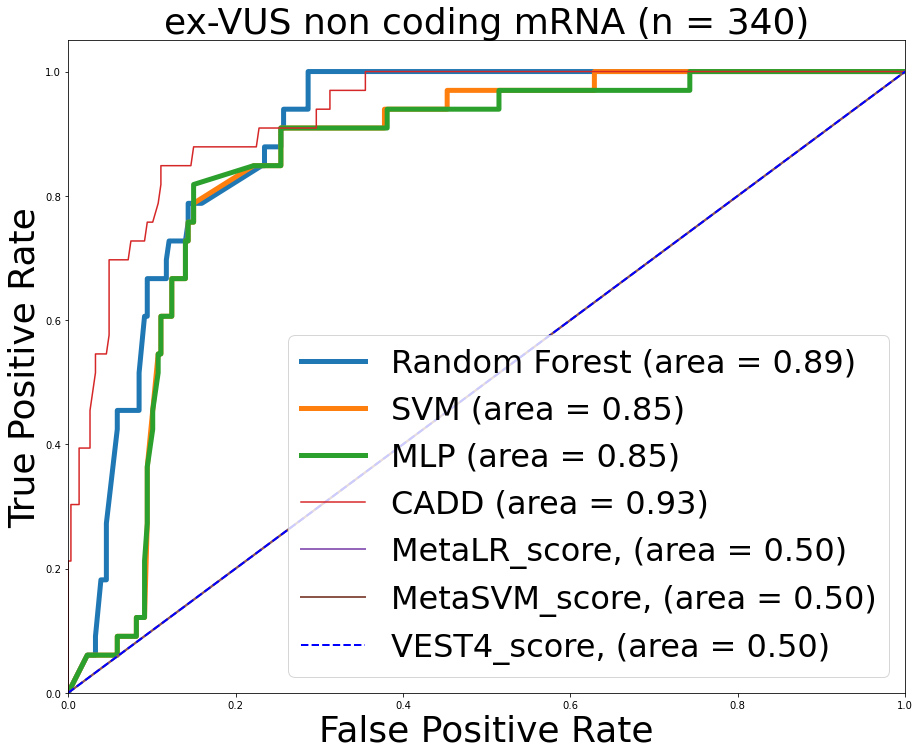

In [61]:
plotValues(nce, X_nce,y_nce,'non coding mRNA','340')

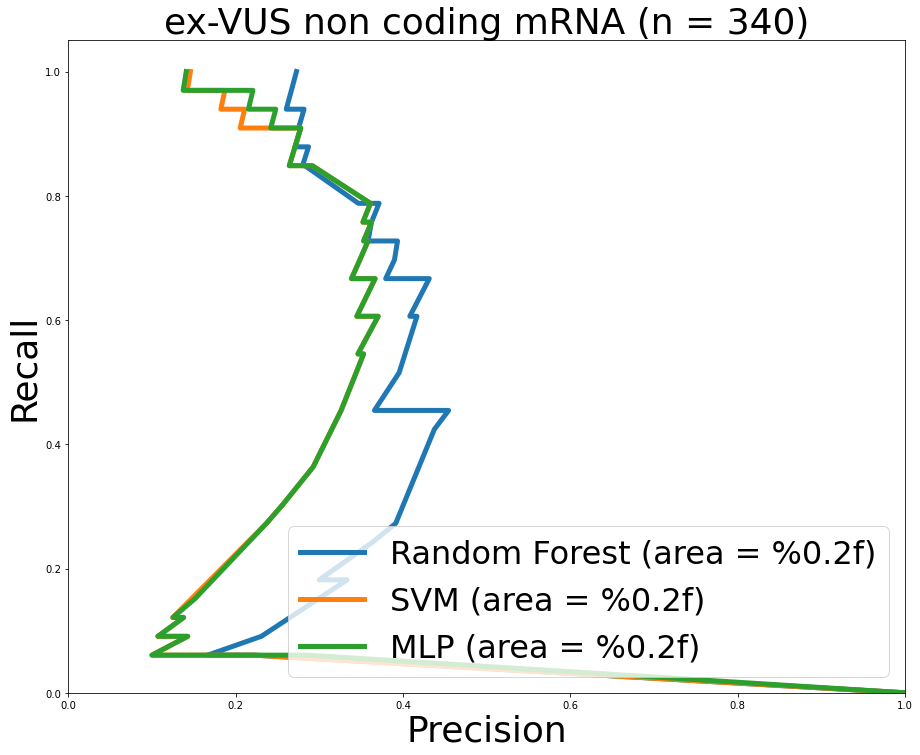

In [153]:
plotValuesPR(nce, X_nce,y_nce,'non coding mRNA','340')

In [91]:
createTables(X_nce,y_nce,'non coding mRNA')

In [233]:
fullMetrics(nce,X_nce,y_nce,'non coding mRNA')

non coding mRNA

APPRIS
ROC threshold cutoff: [1.0]

BLOSUM62
ROC threshold cutoff: [1.0]

CADD_PHRED
ROC threshold cutoff: [22.6]

CADD_RAW
ROC threshold cutoff: [2.736976]

CADD_phred
ROC threshold cutoff: [1.0]

CLINSIG
ROC threshold cutoff: [1.0]

DANN_score
ROC threshold cutoff: [1.0]

Eigen-pred_coding
ROC threshold cutoff: [1.0]

FATHMM_score
ROC threshold cutoff: [1.0]

GERP++_RS
ROC threshold cutoff: [1.0]

LINSIGHT
ROC threshold cutoff: [1.0]

LRT_score
ROC threshold cutoff: [1.0]

LoFtool
ROC threshold cutoff: [0.0931]

M-CAP_score
ROC threshold cutoff: [1.0]

MANE
ROC threshold cutoff: [1.0]

MPC_score
ROC threshold cutoff: [1.0]


/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-230-d3134d5e1bef>:28: RuntimeWarning: invalid value encountered in long_scalars
  'PositivePredictiveValue': confusion_matrix(y,output)[1][1] / ( confusion_matrix(y,output)[1][1] + confusion_matrix(y,output)[0][1] ),
/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter t

/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-230-d3134d5e1bef>:28: RuntimeWarning: invalid value encountered in long_scalars
  'PositivePredictiveValue': confusion_matrix(y,output)[1][1] / ( confusion_matrix(y,output)[1][1] + confusion_matrix(y,output)[0][1] ),
/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter t


MVP_score
ROC threshold cutoff: [1.0]

MaxEntScan_alt
ROC threshold cutoff: [1.0]

MaxEntScan_diff
ROC threshold cutoff: [1.0]

MaxEntScan_ref
ROC threshold cutoff: [1.0]

MetaLR_score
ROC threshold cutoff: [1.0]

MetaSVM_score
ROC threshold cutoff: [1.0]

MutPred_score
ROC threshold cutoff: [1.0]

MutationTaster_score
ROC threshold cutoff: [1.0]

MutationAssessor_score
ROC threshold cutoff: [1.0]

PROVEAN_score
ROC threshold cutoff: [1.0]

PolyPhen
ROC threshold cutoff: [1.0]

REVEL_score
ROC threshold cutoff: [1.0]

SIFT
ROC threshold cutoff: [1.0]

TSL
ROC threshold cutoff: [1.0]

VEST4_score
ROC threshold cutoff: [1.0]

ada_score
ROC threshold cutoff: [1.0]


/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-230-d3134d5e1bef>:28: RuntimeWarning: invalid value encountered in long_scalars
  'PositivePredictiveValue': confusion_matrix(y,output)[1][1] / ( confusion_matrix(y,output)[1][1] + confusion_matrix(y,output)[0][1] ),
/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/bioinformatic/ana


Consequence_3_prime_UTR_variant
ROC threshold cutoff: [1.0]

Consequence_5_prime_UTR_variant
ROC threshold cutoff: [1.0]

Consequence_TF_binding_site_variant
ROC threshold cutoff: [1.0]

Consequence_downstream_gene_variant
ROC threshold cutoff: [1.0]

Consequence_frameshift_variant
ROC threshold cutoff: [1.0]

Consequence_inframe_deletion
ROC threshold cutoff: [1.0]

Consequence_inframe_insertion
ROC threshold cutoff: [1.0]

Consequence_intergenic_variant
ROC threshold cutoff: [1.0]

Consequence_intron_variant
ROC threshold cutoff: [1.0]

Consequence_missense_variant
ROC threshold cutoff: [1.0]

Consequence_non_coding_transcript_exon_variant
ROC threshold cutoff: [1.0]

Consequence_protein_altering_variant
ROC threshold cutoff: [1.0]

Consequence_regulatory_region_variant
ROC threshold cutoff: [1.0]

Consequence_splice_acceptor_variant
ROC threshold cutoff: [1.0]

Consequence_splice_donor_variant
ROC threshold cutoff: [1.0]

Consequence_splice_region_variant
ROC threshold cutoff: [1.0

/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-230-d3134d5e1bef>:28: RuntimeWarning: invalid value encountered in long_scalars
  'PositivePredictiveValue': confusion_matrix(y,output)[1][1] / ( confusion_matrix(y,output)[1][1] + confusion_matrix(y,output)[0][1] ),
/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter t


Consequence_start_lost
ROC threshold cutoff: [1.0]

Consequence_stop_gained
ROC threshold cutoff: [1.0]

Consequence_stop_lost
ROC threshold cutoff: [1.0]

Consequence_stop_retained_variant
ROC threshold cutoff: [1.0]

Consequence_synonymous_variant
ROC threshold cutoff: [1.0]

Consequence_upstream_gene_variant
ROC threshold cutoff: [1.0]


,Name,TN,TP,FN,FP,Sensitivity,Specificity,Accuracy,Precision,F1-Score,PositivePredictiveValue,NegativePredictiveValue,MatthewsCorrelation,LogLoss
0,APPRIS,307,0,33,0,0.000000,1.000000,0.902941,0.000000,0.000000,NaN,0.902941,0.000000,3.352293e+00
1,BLOSUM62,307,0,33,0,0.000000,1.000000,0.902941,0.000000,0.000000,NaN,0.902941,0.000000,3.352293e+00
2,CADD_PHRED,262,28,5,45,0.848485,0.853420,0.852941,0.383562,0.528302,0.383562,0.981273,0.506043,5.079338e+00
3,CADD_RAW,262,28,5,45,0.848485,0.853420,0.852941,0.383562,0.528302,0.383562,0.981273,0.506043,5.079338e+00
4,CADD_phred,307,0,33,0,0.000000,1.000000,0.902941,0.000000,0.000000,NaN,0.902941,0.000000,3.352293e+00
5,CLINSIG,307,33,0,0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9.992007e-16
6,DANN_score,307,0,33,0,0.000000,1.000000,0.902941,0.000000,0.000000,NaN,0.902941,0.000000,3.352293e+00
7,Eigen-pred_coding,307,0,33,0,0.000000,1.000000,0.902941,0.000000,0.000000,NaN,0.902941,0.000000,3.352293e+00
8,FATHMM_score,307,0,33,0,0.000000,1.000000,0.902941,0.000000,0.000000,NaN,0.902941,0.000000,3.352293e+00
9,GERP++_RS,307,0,33,0,0.000000,1.000000,0.902941,0.000000,0.000000,NaN,0.902941,0.000000,3.352293e+00


# #Synonymous

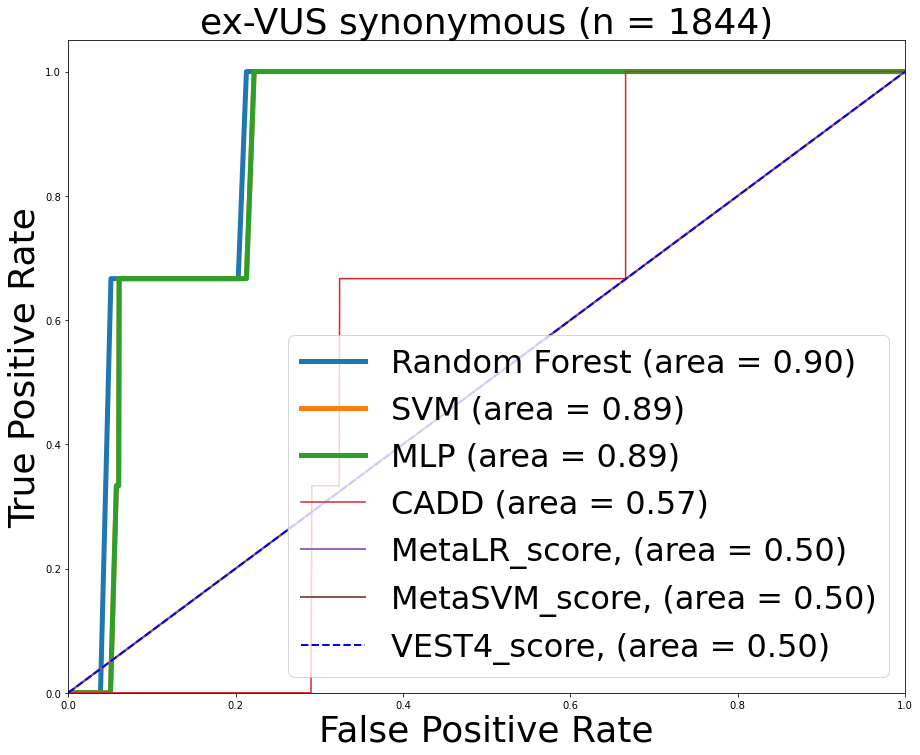

In [62]:
plotValues(syn, X_syn, y_syn, 'synonymous','1844')

In [92]:
createTables(X_syn, y_syn, 'synonymous')

In [234]:
fullMetrics(syn, X_syn, y_syn, 'synonymous')

synonymous

APPRIS
ROC threshold cutoff: [1.0]

BLOSUM62
ROC threshold cutoff: [1.0]

CADD_PHRED
ROC threshold cutoff: [10.03]

CADD_RAW
ROC threshold cutoff: [0.832063]

CADD_phred
ROC threshold cutoff: [1.0]

CLINSIG
ROC threshold cutoff: [1.0]

DANN_score
ROC threshold cutoff: [1.0]


/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-230-d3134d5e1bef>:28: RuntimeWarning: invalid value encountered in long_scalars
  'PositivePredictiveValue': confusion_matrix(y,output)[1][1] / ( confusion_matrix(y,output)[1][1] + confusion_matrix(y,output)[0][1] ),
/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter t


Eigen-pred_coding
ROC threshold cutoff: [1.0]

FATHMM_score
ROC threshold cutoff: [1.0]

GERP++_RS
ROC threshold cutoff: [1.0]

LINSIGHT
ROC threshold cutoff: [1.0]

LRT_score
ROC threshold cutoff: [1.0]

LoFtool
ROC threshold cutoff: [0.0747]

M-CAP_score
ROC threshold cutoff: [1.0]


/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-230-d3134d5e1bef>:28: RuntimeWarning: invalid value encountered in long_scalars
  'PositivePredictiveValue': confusion_matrix(y,output)[1][1] / ( confusion_matrix(y,output)[1][1] + confusion_matrix(y,output)[0][1] ),
/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter t


MANE
ROC threshold cutoff: [1.0]

MPC_score
ROC threshold cutoff: [1.0]

MVP_score
ROC threshold cutoff: [1.0]

MaxEntScan_alt
ROC threshold cutoff: [1.0]

MaxEntScan_diff
ROC threshold cutoff: [1.0]

MaxEntScan_ref
ROC threshold cutoff: [1.0]

MetaLR_score
ROC threshold cutoff: [1.0]


/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-230-d3134d5e1bef>:28: RuntimeWarning: invalid value encountered in long_scalars
  'PositivePredictiveValue': confusion_matrix(y,output)[1][1] / ( confusion_matrix(y,output)[1][1] + confusion_matrix(y,output)[0][1] ),
/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter t


MetaSVM_score
ROC threshold cutoff: [1.0]

MutPred_score
ROC threshold cutoff: [1.0]

MutationTaster_score
ROC threshold cutoff: [1.0]

MutationAssessor_score
ROC threshold cutoff: [1.0]

PROVEAN_score
ROC threshold cutoff: [1.0]

PolyPhen
ROC threshold cutoff: [1.0]

REVEL_score
ROC threshold cutoff: [1.0]


/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-230-d3134d5e1bef>:28: RuntimeWarning: invalid value encountered in long_scalars
  'PositivePredictiveValue': confusion_matrix(y,output)[1][1] / ( confusion_matrix(y,output)[1][1] + confusion_matrix(y,output)[0][1] ),
/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter t


SIFT
ROC threshold cutoff: [1.0]

TSL
ROC threshold cutoff: [1.0]

VEST4_score
ROC threshold cutoff: [1.0]

ada_score
ROC threshold cutoff: [1.0]

Consequence_3_prime_UTR_variant
ROC threshold cutoff: [1.0]

Consequence_5_prime_UTR_variant
ROC threshold cutoff: [1.0]

Consequence_TF_binding_site_variant
ROC threshold cutoff: [1.0]


/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-230-d3134d5e1bef>:28: RuntimeWarning: invalid value encountered in long_scalars
  'PositivePredictiveValue': confusion_matrix(y,output)[1][1] / ( confusion_matrix(y,output)[1][1] + confusion_matrix(y,output)[0][1] ),
/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter t


Consequence_downstream_gene_variant
ROC threshold cutoff: [1.0]

Consequence_frameshift_variant
ROC threshold cutoff: [1.0]

Consequence_inframe_deletion
ROC threshold cutoff: [1.0]

Consequence_inframe_insertion
ROC threshold cutoff: [1.0]

Consequence_intergenic_variant
ROC threshold cutoff: [1.0]

Consequence_intron_variant
ROC threshold cutoff: [1.0]

Consequence_missense_variant
ROC threshold cutoff: [1.0]


/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-230-d3134d5e1bef>:28: RuntimeWarning: invalid value encountered in long_scalars
  'PositivePredictiveValue': confusion_matrix(y,output)[1][1] / ( confusion_matrix(y,output)[1][1] + confusion_matrix(y,output)[0][1] ),
/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter t


Consequence_non_coding_transcript_exon_variant
ROC threshold cutoff: [1.0]

Consequence_protein_altering_variant
ROC threshold cutoff: [1.0]

Consequence_regulatory_region_variant
ROC threshold cutoff: [1.0]

Consequence_splice_acceptor_variant
ROC threshold cutoff: [1.0]

Consequence_splice_donor_variant
ROC threshold cutoff: [1.0]

Consequence_splice_region_variant
ROC threshold cutoff: [1.0]

Consequence_start_lost
ROC threshold cutoff: [1.0]


/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-230-d3134d5e1bef>:28: RuntimeWarning: invalid value encountered in long_scalars
  'PositivePredictiveValue': confusion_matrix(y,output)[1][1] / ( confusion_matrix(y,output)[1][1] + confusion_matrix(y,output)[0][1] ),
/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter t


Consequence_stop_gained
ROC threshold cutoff: [1.0]

Consequence_stop_lost
ROC threshold cutoff: [1.0]

Consequence_stop_retained_variant
ROC threshold cutoff: [1.0]

Consequence_synonymous_variant
ROC threshold cutoff: [1.0]

Consequence_upstream_gene_variant
ROC threshold cutoff: [1.0]


,Name,TN,TP,FN,FP,Sensitivity,Specificity,Accuracy,Precision,F1-Score,PositivePredictiveValue,NegativePredictiveValue,MatthewsCorrelation,LogLoss
0,APPRIS,1841,0,3,0,0.000000,1.000000,0.998373,0.000000,0.000000,NaN,0.998373,0.000000,5.619107e-02
1,BLOSUM62,1841,0,3,0,0.000000,1.000000,0.998373,0.000000,0.000000,NaN,0.998373,0.000000,5.619107e-02
2,CADD_PHRED,1226,2,1,615,0.666667,0.665942,0.665944,0.003241,0.006452,0.003241,0.999185,0.028409,1.153817e+01
3,CADD_RAW,1245,2,1,596,0.666667,0.676263,0.676247,0.003344,0.006656,0.003344,0.999197,0.029525,1.118228e+01
4,CADD_phred,1841,0,3,0,0.000000,1.000000,0.998373,0.000000,0.000000,NaN,0.998373,0.000000,5.619107e-02
5,CLINSIG,1841,3,0,0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9.992007e-16
6,DANN_score,1841,0,3,0,0.000000,1.000000,0.998373,0.000000,0.000000,NaN,0.998373,0.000000,5.619107e-02
7,Eigen-pred_coding,1841,0,3,0,0.000000,1.000000,0.998373,0.000000,0.000000,NaN,0.998373,0.000000,5.619107e-02
8,FATHMM_score,1841,0,3,0,0.000000,1.000000,0.998373,0.000000,0.000000,NaN,0.998373,0.000000,5.619107e-02
9,GERP++_RS,1841,0,3,0,0.000000,1.000000,0.998373,0.000000,0.000000,NaN,0.998373,0.000000,5.619107e-02


## Other 

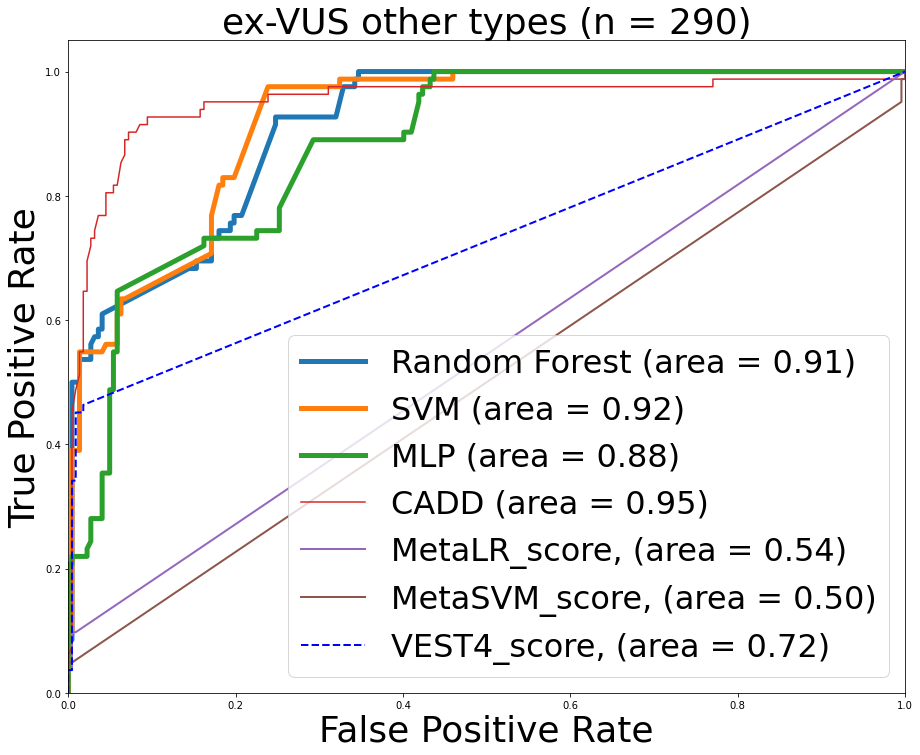

In [63]:
plotValues(oth, X_oth, y_oth, 'other types','290')

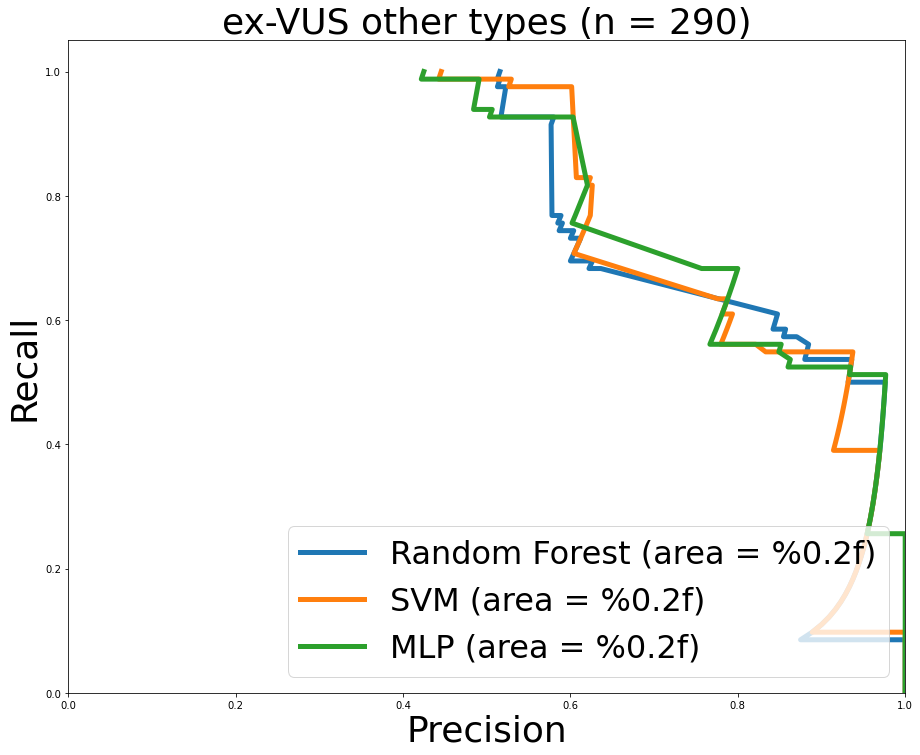

In [154]:
plotValuesPR(oth, X_oth, y_oth, 'other types','290')

In [93]:
createTables(X_oth, y_oth, 'other types')

In [235]:
fullMetrics(oth, X_oth, y_oth, 'other types')

other types

APPRIS
ROC threshold cutoff: [1.0]

BLOSUM62
ROC threshold cutoff: [1.0]

CADD_PHRED
ROC threshold cutoff: [22.6]

CADD_RAW
ROC threshold cutoff: [2.715461]

CADD_phred
ROC threshold cutoff: [17.48]

CLINSIG
ROC threshold cutoff: [1.0]

DANN_score
ROC threshold cutoff: [0.6162634766968869]

Eigen-pred_coding
ROC threshold cutoff: [0.468663]

FATHMM_score
ROC threshold cutoff: [0.0]

GERP++_RS
ROC threshold cutoff: [1.82]

LINSIGHT
ROC threshold cutoff: [0.934252]

LRT_score
ROC threshold cutoff: [1e-06]

LoFtool
ROC threshold cutoff: [0.105]

M-CAP_score
ROC threshold cutoff: [0.006209]

MANE
ROC threshold cutoff: [1.0]


/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-230-d3134d5e1bef>:28: RuntimeWarning: invalid value encountered in long_scalars
  'PositivePredictiveValue': confusion_matrix(y,output)[1][1] / ( confusion_matrix(y,output)[1][1] + confusion_matrix(y,output)[0][1] ),
/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter t


MPC_score
ROC threshold cutoff: [1.0]

MVP_score
ROC threshold cutoff: [0.130388298395]

MaxEntScan_alt
ROC threshold cutoff: [1.075]

MaxEntScan_diff
ROC threshold cutoff: [0.49]

MaxEntScan_ref
ROC threshold cutoff: [3.781]

MetaLR_score
ROC threshold cutoff: [0.0118]

MetaSVM_score
ROC threshold cutoff: [0.3041]

MutPred_score
ROC threshold cutoff: [0.617]

MutationTaster_score
ROC threshold cutoff: [0.897272]

MutationAssessor_score
ROC threshold cutoff: [0.0]

PROVEAN_score
ROC threshold cutoff: [0.0]

PolyPhen
ROC threshold cutoff: [0.006]

REVEL_score
ROC threshold cutoff: [0.165]

SIFT
ROC threshold cutoff: [0.01]

TSL
ROC threshold cutoff: [1.0]

VEST4_score
ROC threshold cutoff: [0.229]


/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-230-d3134d5e1bef>:28: RuntimeWarning: invalid value encountered in long_scalars
  'PositivePredictiveValue': confusion_matrix(y,output)[1][1] / ( confusion_matrix(y,output)[1][1] + confusion_matrix(y,output)[0][1] ),
/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)



ada_score
ROC threshold cutoff: [1.47251461681121e-05]

Consequence_3_prime_UTR_variant
ROC threshold cutoff: [1.0]

Consequence_5_prime_UTR_variant
ROC threshold cutoff: [1.0]

Consequence_TF_binding_site_variant
ROC threshold cutoff: [1.0]

Consequence_downstream_gene_variant
ROC threshold cutoff: [1.0]

Consequence_frameshift_variant
ROC threshold cutoff: [1.0]

Consequence_inframe_deletion
ROC threshold cutoff: [1.0]

Consequence_inframe_insertion
ROC threshold cutoff: [1.0]

Consequence_intergenic_variant
ROC threshold cutoff: [1.0]

Consequence_intron_variant
ROC threshold cutoff: [1.0]

Consequence_missense_variant
ROC threshold cutoff: [1.0]

Consequence_non_coding_transcript_exon_variant
ROC threshold cutoff: [1.0]

Consequence_protein_altering_variant
ROC threshold cutoff: [1.0]

Consequence_regulatory_region_variant
ROC threshold cutoff: [1.0]

Consequence_splice_acceptor_variant
ROC threshold cutoff: [1.0]

Consequence_splice_donor_variant
ROC threshold cutoff: [1.0]


/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-230-d3134d5e1bef>:28: RuntimeWarning: invalid value encountered in long_scalars
  'PositivePredictiveValue': confusion_matrix(y,output)[1][1] / ( confusion_matrix(y,output)[1][1] + confusion_matrix(y,output)[0][1] ),
/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter t


Consequence_splice_region_variant
ROC threshold cutoff: [1.0]

Consequence_start_lost
ROC threshold cutoff: [1.0]

Consequence_stop_gained
ROC threshold cutoff: [1.0]

Consequence_stop_lost
ROC threshold cutoff: [1.0]

Consequence_stop_retained_variant
ROC threshold cutoff: [1.0]

Consequence_synonymous_variant
ROC threshold cutoff: [1.0]

Consequence_upstream_gene_variant
ROC threshold cutoff: [1.0]


/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-230-d3134d5e1bef>:28: RuntimeWarning: invalid value encountered in long_scalars
  'PositivePredictiveValue': confusion_matrix(y,output)[1][1] / ( confusion_matrix(y,output)[1][1] + confusion_matrix(y,output)[0][1] ),
/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter t

,Name,TN,TP,FN,FP,Sensitivity,Specificity,Accuracy,Precision,F1-Score,PositivePredictiveValue,NegativePredictiveValue,MatthewsCorrelation,LogLoss
0,APPRIS,222,0,82,0,0.000000,1.000000,0.730263,0.000000,0.000000,NaN,0.730263,0.000000,9.316380e+00
1,BLOSUM62,220,6,76,2,0.073171,0.990991,0.743421,0.750000,0.133333,0.750000,0.743243,0.177897,8.861928e+00
2,CADD_PHRED,203,75,7,19,0.914634,0.914414,0.914474,0.797872,0.852273,0.797872,0.966667,0.796141,2.954024e+00
3,CADD_RAW,203,75,7,19,0.914634,0.914414,0.914474,0.797872,0.852273,0.797872,0.966667,0.796141,2.954024e+00
4,CADD_phred,218,38,44,4,0.463415,0.981982,0.842105,0.904762,0.612903,0.904762,0.832061,0.572869,5.453502e+00
5,CLINSIG,222,82,0,0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9.992007e-16
6,DANN_score,218,38,44,4,0.463415,0.981982,0.842105,0.904762,0.612903,0.904762,0.832061,0.572869,5.453502e+00
7,Eigen-pred_coding,218,38,44,4,0.463415,0.981982,0.842105,0.904762,0.612903,0.904762,0.832061,0.572869,5.453502e+00
8,FATHMM_score,1,78,4,221,0.951220,0.004505,0.259868,0.260870,0.409449,0.260870,0.200000,-0.154501,2.556382e+01
9,GERP++_RS,219,37,45,3,0.451220,0.986486,0.842105,0.925000,0.606557,0.925000,0.829545,0.574690,5.453499e+00


# # Splice

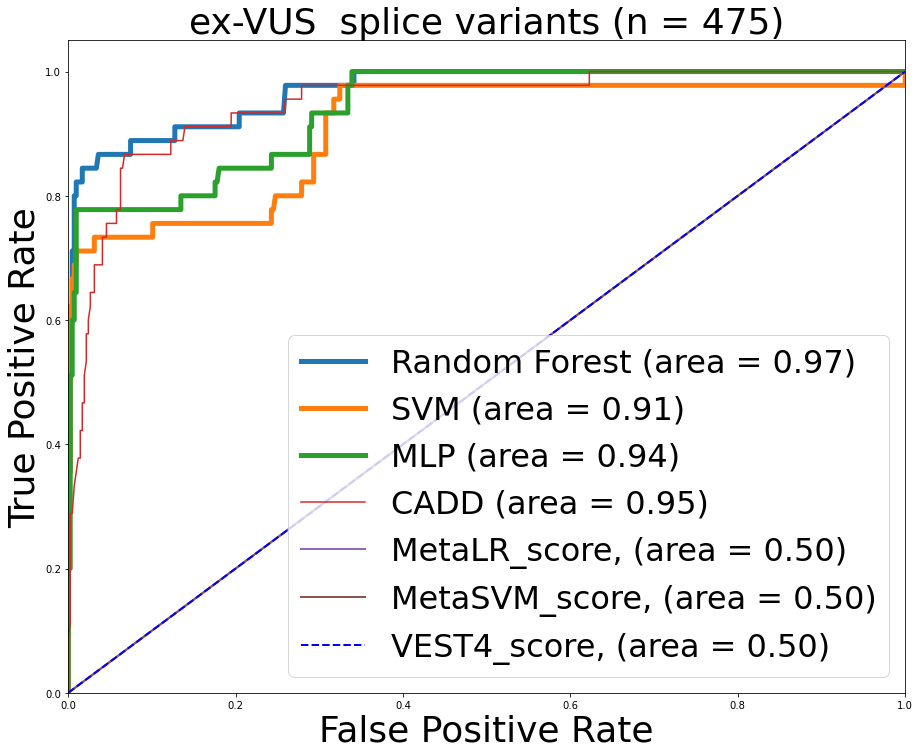

In [64]:
plotValues(spl, X_spl, y_spl, ' splice variants','475')

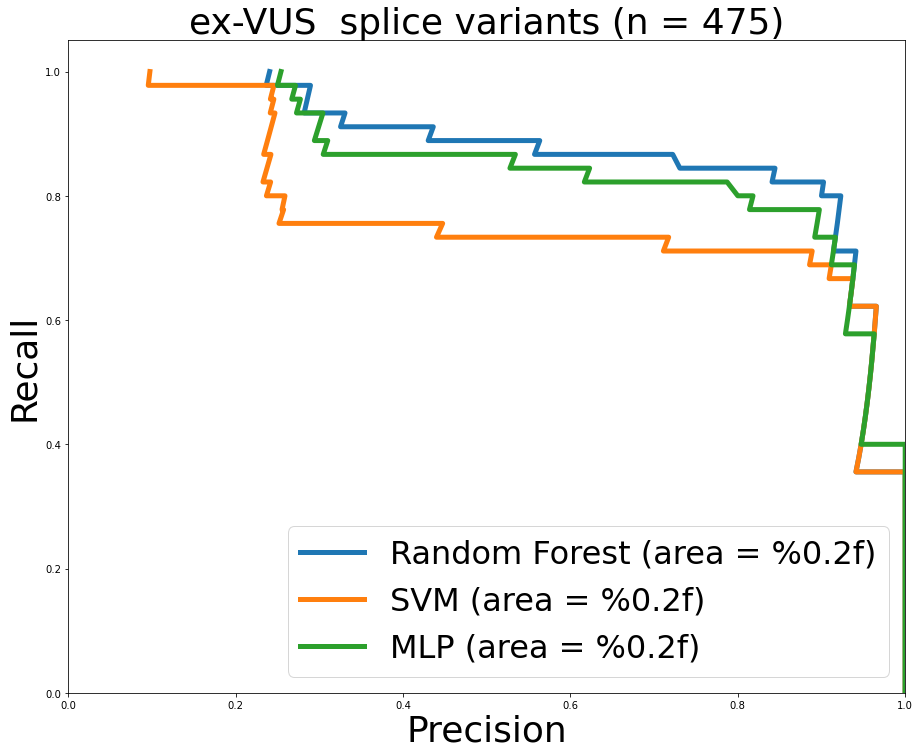

In [155]:
plotValuesPR(spl, X_spl, y_spl, ' splice variants','475')

In [94]:
createTables(X_spl, y_spl, ' splice variants')

In [236]:
fullMetrics(spl, X_spl, y_spl, ' splice variants')

 splice variants

APPRIS
ROC threshold cutoff: [1.0]

BLOSUM62
ROC threshold cutoff: [1.0]

CADD_PHRED
ROC threshold cutoff: [16.0]

CADD_RAW
ROC threshold cutoff: [1.550817]

CADD_phred
ROC threshold cutoff: [1.0]

CLINSIG
ROC threshold cutoff: [1.0]

DANN_score
ROC threshold cutoff: [1.0]

Eigen-pred_coding
ROC threshold cutoff: [1.0]

FATHMM_score
ROC threshold cutoff: [1.0]

GERP++_RS
ROC threshold cutoff: [1.0]

LINSIGHT
ROC threshold cutoff: [1.0]

LRT_score
ROC threshold cutoff: [1.0]

LoFtool
ROC threshold cutoff: [0.0899]

M-CAP_score
ROC threshold cutoff: [1.0]


/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-230-d3134d5e1bef>:28: RuntimeWarning: invalid value encountered in long_scalars
  'PositivePredictiveValue': confusion_matrix(y,output)[1][1] / ( confusion_matrix(y,output)[1][1] + confusion_matrix(y,output)[0][1] ),
/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter t


MANE
ROC threshold cutoff: [1.0]

MPC_score
ROC threshold cutoff: [1.0]

MVP_score
ROC threshold cutoff: [1.0]

MaxEntScan_alt
ROC threshold cutoff: [4.888]

MaxEntScan_diff
ROC threshold cutoff: [1.557]

MaxEntScan_ref
ROC threshold cutoff: [8.626]

MetaLR_score
ROC threshold cutoff: [1.0]

MetaSVM_score
ROC threshold cutoff: [1.0]

MutPred_score
ROC threshold cutoff: [1.0]

MutationTaster_score
ROC threshold cutoff: [1.0]

MutationAssessor_score
ROC threshold cutoff: [1.0]

PROVEAN_score
ROC threshold cutoff: [1.0]

PolyPhen
ROC threshold cutoff: [1.0]

REVEL_score
ROC threshold cutoff: [1.0]


/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-230-d3134d5e1bef>:28: RuntimeWarning: invalid value encountered in long_scalars
  'PositivePredictiveValue': confusion_matrix(y,output)[1][1] / ( confusion_matrix(y,output)[1][1] + confusion_matrix(y,output)[0][1] ),
/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter t


SIFT
ROC threshold cutoff: [1.0]

TSL
ROC threshold cutoff: [1.0]

VEST4_score
ROC threshold cutoff: [1.0]

ada_score
ROC threshold cutoff: [0.00542069485113043]

Consequence_3_prime_UTR_variant
ROC threshold cutoff: [1.0]

Consequence_5_prime_UTR_variant
ROC threshold cutoff: [1.0]

Consequence_TF_binding_site_variant
ROC threshold cutoff: [1.0]

Consequence_downstream_gene_variant
ROC threshold cutoff: [1.0]

Consequence_frameshift_variant
ROC threshold cutoff: [1.0]

Consequence_inframe_deletion
ROC threshold cutoff: [1.0]

Consequence_inframe_insertion
ROC threshold cutoff: [1.0]

Consequence_intergenic_variant
ROC threshold cutoff: [1.0]

Consequence_intron_variant
ROC threshold cutoff: [1.0]

Consequence_missense_variant
ROC threshold cutoff: [1.0]

Consequence_non_coding_transcript_exon_variant


/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-230-d3134d5e1bef>:28: RuntimeWarning: invalid value encountered in long_scalars
  'PositivePredictiveValue': confusion_matrix(y,output)[1][1] / ( confusion_matrix(y,output)[1][1] + confusion_matrix(y,output)[0][1] ),
/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter t

ROC threshold cutoff: [1.0]

Consequence_protein_altering_variant
ROC threshold cutoff: [1.0]

Consequence_regulatory_region_variant
ROC threshold cutoff: [1.0]

Consequence_splice_acceptor_variant
ROC threshold cutoff: [1.0]

Consequence_splice_donor_variant
ROC threshold cutoff: [1.0]

Consequence_splice_region_variant
ROC threshold cutoff: [1.0]

Consequence_start_lost
ROC threshold cutoff: [1.0]

Consequence_stop_gained
ROC threshold cutoff: [1.0]

Consequence_stop_lost
ROC threshold cutoff: [1.0]

Consequence_stop_retained_variant
ROC threshold cutoff: [1.0]

Consequence_synonymous_variant
ROC threshold cutoff: [1.0]

Consequence_upstream_gene_variant
ROC threshold cutoff: [1.0]


<ipython-input-230-d3134d5e1bef>:28: RuntimeWarning: invalid value encountered in long_scalars
  'PositivePredictiveValue': confusion_matrix(y,output)[1][1] / ( confusion_matrix(y,output)[1][1] + confusion_matrix(y,output)[0][1] ),
/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-230-d3134d5e1bef>:28: RuntimeWarning: invalid value encountered in long_scalars
  'PositivePredictiveValue': confusion_matrix(y,output)[1][1] / ( confusion_matrix(y,output)[1][1] + confusion_matrix(y,output)[0][1] ),
/home

,Name,TN,TP,FN,FP,Sensitivity,Specificity,Accuracy,Precision,F1-Score,PositivePredictiveValue,NegativePredictiveValue,MatthewsCorrelation,LogLoss
0,APPRIS,416,0,45,0,0.000000,1.000000,0.902386,0.000000,0.000000,NaN,0.902386,0.000000,3.371464e+00
1,BLOSUM62,416,0,45,0,0.000000,1.000000,0.902386,0.000000,0.000000,NaN,0.902386,0.000000,3.371464e+00
2,CADD_PHRED,365,39,6,51,0.866667,0.877404,0.876356,0.433333,0.577778,0.433333,0.983827,0.557133,4.270610e+00
3,CADD_RAW,365,39,6,51,0.866667,0.877404,0.876356,0.433333,0.577778,0.433333,0.983827,0.557133,4.270610e+00
4,CADD_phred,416,0,45,0,0.000000,1.000000,0.902386,0.000000,0.000000,NaN,0.902386,0.000000,3.371464e+00
5,CLINSIG,416,45,0,0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9.992007e-16
6,DANN_score,416,0,45,0,0.000000,1.000000,0.902386,0.000000,0.000000,NaN,0.902386,0.000000,3.371464e+00
7,Eigen-pred_coding,416,0,45,0,0.000000,1.000000,0.902386,0.000000,0.000000,NaN,0.902386,0.000000,3.371464e+00
8,FATHMM_score,416,0,45,0,0.000000,1.000000,0.902386,0.000000,0.000000,NaN,0.902386,0.000000,3.371464e+00
9,GERP++_RS,416,0,45,0,0.000000,1.000000,0.902386,0.000000,0.000000,NaN,0.902386,0.000000,3.371464e+00


# # coding INDELs

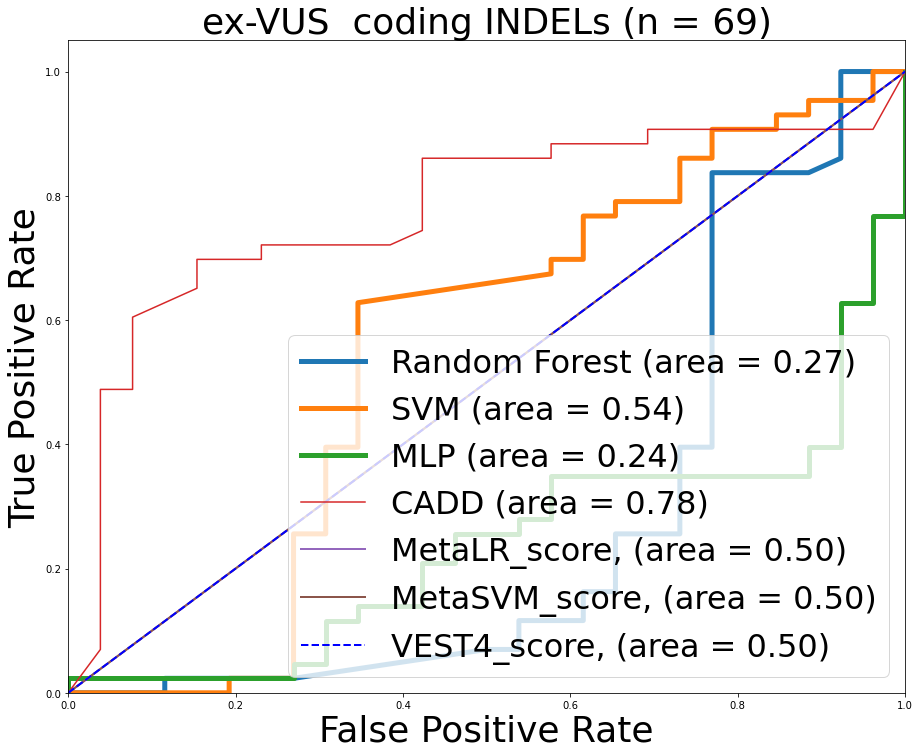

In [65]:
plotValues(indl, X_indl, y_indl, ' coding INDELs', '69')

In [ ]:
createTables(X_indl, y_indl, ' coding INDELs')

In [237]:
fullMetrics(indl, X_indl, y_indl, ' coding INDELs')

 coding INDELs

APPRIS
ROC threshold cutoff: [1.0]

BLOSUM62
ROC threshold cutoff: [1.0]

CADD_PHRED
ROC threshold cutoff: [20.8]

CADD_RAW
ROC threshold cutoff: [2.364479]

CADD_phred
ROC threshold cutoff: [1.0]

CLINSIG
ROC threshold cutoff: [1.0]

DANN_score
ROC threshold cutoff: [1.0]

Eigen-pred_coding
ROC threshold cutoff: [1.0]

FATHMM_score
ROC threshold cutoff: [1.0]

GERP++_RS
ROC threshold cutoff: [1.0]

LINSIGHT
ROC threshold cutoff: [1.0]

LRT_score
ROC threshold cutoff: [1.0]

LoFtool
ROC threshold cutoff: [0.0543]

M-CAP_score
ROC threshold cutoff: [1.0]

MANE
ROC threshold cutoff: [1.0]

MPC_score
ROC threshold cutoff: [1.0]

MVP_score
ROC threshold cutoff: [1.0]

MaxEntScan_alt
ROC threshold cutoff: [1.0]

MaxEntScan_diff
ROC threshold cutoff: [1.0]

MaxEntScan_ref
ROC threshold cutoff: [1.0]

MetaLR_score
ROC threshold cutoff: [1.0]


/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-230-d3134d5e1bef>:28: RuntimeWarning: invalid value encountered in long_scalars
  'PositivePredictiveValue': confusion_matrix(y,output)[1][1] / ( confusion_matrix(y,output)[1][1] + confusion_matrix(y,output)[0][1] ),
/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter t


MetaSVM_score
ROC threshold cutoff: [1.0]

MutPred_score
ROC threshold cutoff: [1.0]

MutationTaster_score
ROC threshold cutoff: [1.0]

MutationAssessor_score
ROC threshold cutoff: [1.0]

PROVEAN_score
ROC threshold cutoff: [1.0]

PolyPhen
ROC threshold cutoff: [1.0]

REVEL_score
ROC threshold cutoff: [1.0]

SIFT
ROC threshold cutoff: [1.0]

TSL
ROC threshold cutoff: [1.0]

VEST4_score
ROC threshold cutoff: [1.0]

ada_score
ROC threshold cutoff: [1.0]

Consequence_3_prime_UTR_variant
ROC threshold cutoff: [1.0]

Consequence_5_prime_UTR_variant
ROC threshold cutoff: [1.0]

Consequence_TF_binding_site_variant
ROC threshold cutoff: [1.0]

Consequence_downstream_gene_variant
ROC threshold cutoff: [1.0]

Consequence_frameshift_variant
ROC threshold cutoff: [1.0]

Consequence_inframe_deletion
ROC threshold cutoff: [1.0]

Consequence_inframe_insertion
ROC threshold cutoff: [1.0]

Consequence_intergenic_variant
ROC threshold cutoff: [1.0]

Consequence_intron_variant
ROC threshold cutoff: [1.0

/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-230-d3134d5e1bef>:28: RuntimeWarning: invalid value encountered in long_scalars
  'PositivePredictiveValue': confusion_matrix(y,output)[1][1] / ( confusion_matrix(y,output)[1][1] + confusion_matrix(y,output)[0][1] ),
/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter t


Consequence_non_coding_transcript_exon_variant
ROC threshold cutoff: [1.0]

Consequence_protein_altering_variant
ROC threshold cutoff: [1.0]

Consequence_regulatory_region_variant
ROC threshold cutoff: [1.0]

Consequence_splice_acceptor_variant
ROC threshold cutoff: [1.0]

Consequence_splice_donor_variant
ROC threshold cutoff: [1.0]

Consequence_splice_region_variant
ROC threshold cutoff: [1.0]

Consequence_start_lost
ROC threshold cutoff: [1.0]

Consequence_stop_gained
ROC threshold cutoff: [1.0]

Consequence_stop_lost
ROC threshold cutoff: [1.0]

Consequence_stop_retained_variant
ROC threshold cutoff: [1.0]

Consequence_synonymous_variant
ROC threshold cutoff: [1.0]

Consequence_upstream_gene_variant
ROC threshold cutoff: [1.0]


/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-230-d3134d5e1bef>:28: RuntimeWarning: invalid value encountered in long_scalars
  'PositivePredictiveValue': confusion_matrix(y,output)[1][1] / ( confusion_matrix(y,output)[1][1] + confusion_matrix(y,output)[0][1] ),
/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter t

,Name,TN,TP,FN,FP,Sensitivity,Specificity,Accuracy,Precision,F1-Score,PositivePredictiveValue,NegativePredictiveValue,MatthewsCorrelation,LogLoss
0,APPRIS,26,0,43,0,0.000000,1.000000,0.376812,0.000000,0.000000,NaN,0.376812,0.000000,2.152416e+01
1,BLOSUM62,26,0,43,0,0.000000,1.000000,0.376812,0.000000,0.000000,NaN,0.376812,0.000000,2.152416e+01
2,CADD_PHRED,18,31,12,8,0.720930,0.692308,0.710145,0.794872,0.756098,0.794872,0.600000,0.403950,1.001133e+01
3,CADD_RAW,20,31,12,6,0.720930,0.769231,0.739130,0.837838,0.775000,0.837838,0.625000,0.476304,9.010185e+00
4,CADD_phred,26,0,43,0,0.000000,1.000000,0.376812,0.000000,0.000000,NaN,0.376812,0.000000,2.152416e+01
5,CLINSIG,26,43,0,0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9.992007e-16
6,DANN_score,26,0,43,0,0.000000,1.000000,0.376812,0.000000,0.000000,NaN,0.376812,0.000000,2.152416e+01
7,Eigen-pred_coding,26,0,43,0,0.000000,1.000000,0.376812,0.000000,0.000000,NaN,0.376812,0.000000,2.152416e+01
8,FATHMM_score,26,0,43,0,0.000000,1.000000,0.376812,0.000000,0.000000,NaN,0.376812,0.000000,2.152416e+01
9,GERP++_RS,26,0,43,0,0.000000,1.000000,0.376812,0.000000,0.000000,NaN,0.376812,0.000000,2.152416e+01


## Intergenic

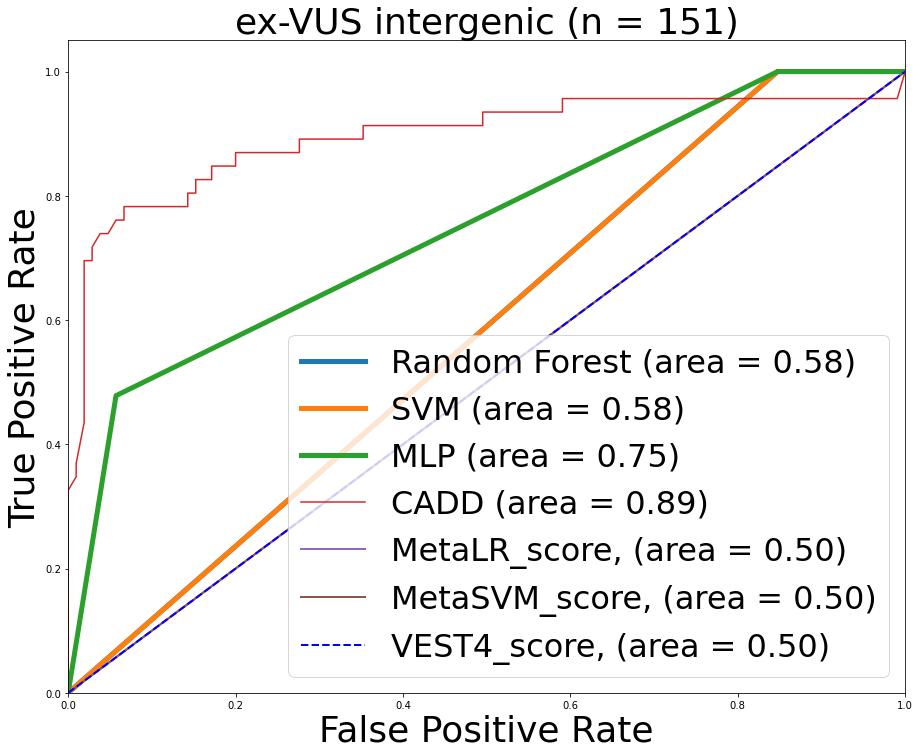

In [66]:
plotValues(ign, X_ign, y_ign, 'intergenic', '151')

In [95]:
createTables(X_ign, y_ign, 'intergenic')

In [238]:
fullMetrics(ign, X_ign, y_ign, 'intergenic')

intergenic

APPRIS
ROC threshold cutoff: [1.0]

BLOSUM62
ROC threshold cutoff: [1.0]

CADD_PHRED
ROC threshold cutoff: [18.62]

CADD_RAW
ROC threshold cutoff: [1.985752]

CADD_phred
ROC threshold cutoff: [1.0]

CLINSIG
ROC threshold cutoff: [1.0]

DANN_score
ROC threshold cutoff: [1.0]

Eigen-pred_coding
ROC threshold cutoff: [1.0]

FATHMM_score
ROC threshold cutoff: [1.0]

GERP++_RS
ROC threshold cutoff: [1.0]

LINSIGHT
ROC threshold cutoff: [1.0]

LRT_score
ROC threshold cutoff: [1.0]

LoFtool
ROC threshold cutoff: [1.0]

M-CAP_score
ROC threshold cutoff: [1.0]

MANE
ROC threshold cutoff: [1.0]

MPC_score
ROC threshold cutoff: [1.0]

MVP_score
ROC threshold cutoff: [1.0]

MaxEntScan_alt
ROC threshold cutoff: [1.0]

MaxEntScan_diff


/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-230-d3134d5e1bef>:28: RuntimeWarning: invalid value encountered in long_scalars
  'PositivePredictiveValue': confusion_matrix(y,output)[1][1] / ( confusion_matrix(y,output)[1][1] + confusion_matrix(y,output)[0][1] ),
/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter t

ROC threshold cutoff: [1.0]

MaxEntScan_ref
ROC threshold cutoff: [1.0]

MetaLR_score
ROC threshold cutoff: [1.0]

MetaSVM_score
ROC threshold cutoff: [1.0]

MutPred_score
ROC threshold cutoff: [1.0]

MutationTaster_score
ROC threshold cutoff: [1.0]

MutationAssessor_score
ROC threshold cutoff: [1.0]

PROVEAN_score
ROC threshold cutoff: [1.0]

PolyPhen
ROC threshold cutoff: [1.0]

REVEL_score
ROC threshold cutoff: [1.0]

SIFT
ROC threshold cutoff: [1.0]

TSL
ROC threshold cutoff: [1.0]

VEST4_score
ROC threshold cutoff: [1.0]

ada_score
ROC threshold cutoff: [1.0]

Consequence_3_prime_UTR_variant
ROC threshold cutoff: [1.0]

Consequence_5_prime_UTR_variant
ROC threshold cutoff: [1.0]

Consequence_TF_binding_site_variant
ROC threshold cutoff: [1.0]

Consequence_downstream_gene_variant
ROC threshold cutoff: [1.0]

Consequence_frameshift_variant
ROC threshold cutoff: [1.0]


/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-230-d3134d5e1bef>:28: RuntimeWarning: invalid value encountered in long_scalars
  'PositivePredictiveValue': confusion_matrix(y,output)[1][1] / ( confusion_matrix(y,output)[1][1] + confusion_matrix(y,output)[0][1] ),
/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/bioinformatic/ana


Consequence_inframe_deletion
ROC threshold cutoff: [1.0]

Consequence_inframe_insertion
ROC threshold cutoff: [1.0]

Consequence_intergenic_variant
ROC threshold cutoff: [1.0]

Consequence_intron_variant
ROC threshold cutoff: [1.0]

Consequence_missense_variant
ROC threshold cutoff: [1.0]

Consequence_non_coding_transcript_exon_variant
ROC threshold cutoff: [1.0]

Consequence_protein_altering_variant
ROC threshold cutoff: [1.0]

Consequence_regulatory_region_variant
ROC threshold cutoff: [1.0]

Consequence_splice_acceptor_variant
ROC threshold cutoff: [1.0]

Consequence_splice_donor_variant
ROC threshold cutoff: [1.0]

Consequence_splice_region_variant
ROC threshold cutoff: [1.0]

Consequence_start_lost
ROC threshold cutoff: [1.0]

Consequence_stop_gained
ROC threshold cutoff: [1.0]

Consequence_stop_lost
ROC threshold cutoff: [1.0]

Consequence_stop_retained_variant
ROC threshold cutoff: [1.0]

Consequence_synonymous_variant
ROC threshold cutoff: [1.0]

Consequence_upstream_gene_vari

/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-230-d3134d5e1bef>:28: RuntimeWarning: invalid value encountered in long_scalars
  'PositivePredictiveValue': confusion_matrix(y,output)[1][1] / ( confusion_matrix(y,output)[1][1] + confusion_matrix(y,output)[0][1] ),
/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/bioinformatic/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter t

,Name,TN,TP,FN,FP,Sensitivity,Specificity,Accuracy,Precision,F1-Score,PositivePredictiveValue,NegativePredictiveValue,MatthewsCorrelation,LogLoss
0,APPRIS,105,0,46,0,0.000000,1.000000,0.695364,0.000000,0.000000,NaN,0.695364,0.000000,1.052175e+01
1,BLOSUM62,105,0,46,0,0.000000,1.000000,0.695364,0.000000,0.000000,NaN,0.695364,0.000000,1.052175e+01
2,CADD_PHRED,87,38,8,18,0.826087,0.828571,0.827815,0.678571,0.745098,0.678571,0.915789,0.623781,5.947169e+00
3,CADD_RAW,87,38,8,18,0.826087,0.828571,0.827815,0.678571,0.745098,0.678571,0.915789,0.623781,5.947169e+00
4,CADD_phred,105,0,46,0,0.000000,1.000000,0.695364,0.000000,0.000000,NaN,0.695364,0.000000,1.052175e+01
5,CLINSIG,105,46,0,0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9.992007e-16
6,DANN_score,105,0,46,0,0.000000,1.000000,0.695364,0.000000,0.000000,NaN,0.695364,0.000000,1.052175e+01
7,Eigen-pred_coding,105,0,46,0,0.000000,1.000000,0.695364,0.000000,0.000000,NaN,0.695364,0.000000,1.052175e+01
8,FATHMM_score,105,0,46,0,0.000000,1.000000,0.695364,0.000000,0.000000,NaN,0.695364,0.000000,1.052175e+01
9,GERP++_RS,105,0,46,0,0.000000,1.000000,0.695364,0.000000,0.000000,NaN,0.695364,0.000000,1.052175e+01


# Predicting classification of current VUS

In [ ]:
#Function to process current VUS dataset
def processModelVUS(df):
    df['codon_degeneracy'] = df['codon_degeneracy'].str.split(',').str[0]
    df['Consequence'] = df['Consequence'].str.split(',').str[0]
    df = df.replace({'codon_degeneracy':'-'},0)
    df=pd.get_dummies(df,columns=['Consequence'])
    df = df.filter(['ada_score','AF','BLOSUM62','CADD_PHRED','codon_degeneracy','Eigen-pred_coding','GERP++_RS', 
              'integrated_fitCons_score','LoFtool','phyloP100way_vertebrate','SIFT', 'Consequence_5_prime_UTR_variant',
              'Consequence_downstream_gene_variant', 'Consequence_frameshift_variant',
              'Consequence_inframe_deletion', 'Consequence_inframe_insertion',
              'Consequence_intron_variant', 'Consequence_missense_variant',
              'Consequence_non_coding_transcript_exon_variant',
              'Consequence_splice_donor_variant', 'Consequence_splice_region_variant',
              'Consequence_start_lost', 'Consequence_stop_gained',
              'Consequence_synonymous_variant', 'Consequence_upstream_gene_variant'])
    df = df.replace({'ada_score': "-", 'AF': "-", 'CADD_PHRED':"-", 'Eigen-pred_coding': '-',
               'integrated_fitCons_score': '-', 'LoFtool': '-', 'phyloP100way_vertebrate':'-',
               'SIFT': '-'}, -1)
    df = df.replace({'BLOSUM62':"-", 'GERP++_RS':'-'}, 0)
    df = df.replace(".",0)   
    df = df.astype(float)
    scaler = MinMaxScaler(feature_range=(0, 1), copy=True)
    scaler.fit (df)
    return df


In [ ]:
#Processing current VUS dataset
vus_model = processModelVUS(vus)
vus_model = completeColumns(vus_model)

In [ ]:
#Predicting classification of current VUS with the RF tool
predict_RF_vus=clf_RF.predict(vus_model)
predict_RF_vus

arr=plt.hist(predict_RF_vus)
for i in range(10):
    plt.text(arr[1][i],arr[0][i],str(arr[0][i]))

In [ ]:
#Predicting classification of current VUS with the SVM tool
predict_svm=svm_modelo.predict(vus_model)
predict_svm

arr=plt.hist(predict_svm)
for i in range(10):
    plt.text(arr[1][i],arr[0][i],str(arr[0][i]))

In [ ]:
#Predicting classification of current VUS with the MLP tool
predict_red=red_modelo.predict_classes(vus_model)
predict_red
arr=plt.hist(predict_red)
for i in range(10):
    plt.text(arr[1][i],arr[0][i],str(arr[0][i]))

In [ ]:
#Plotting current VUS classification with the RF model
score_RF_vus=clf_RF.predict_proba(vus_model)
plt.figure(figsize=(15,12))
plt.hist(score_RF_vus[:,1],bins=100)

In [ ]:
#Plot prediction of the RF model for missense variants from the current VUS set
vus_miss =vus[(vus['REVEL_score']!= "-") & (vus['SIFT']!= "-") & (vus['PolyPhen']!= "-")]
vus_miss = processModelVUS(vus_miss)
vus_miss = completeColumns(vus_miss)
score_RF_pred=clf_RF.predict_proba(vus_miss)
plt.figure(figsize=(15,12))
plt.hist(score_RF_pred)

In [ ]:
#Plot prediction of the SVM model for missense variants from the current VUS set

score_SVM_vus_miss=svm_modelo.predict_proba(vus_miss)
score_SVM_vus_miss
plt.figure(figsize=(15,12))
plt.hist(score_SVM_vus_miss[:,1],bins=100)

In [ ]:
#Plot prediction of the MLP model for missense variants from the current VUS set

score_MLP_vus_miss=red_modelo.predict_proba(vus_miss)
score_MLP_vus_miss
plt.figure(figsize=(15,12))
plt.hist(score_MLP_vus_miss,bins=100)